In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns
import gc

/kaggle/input/santander-pr/sample_submission.csv
/kaggle/input/santander-pr/train.csv
/kaggle/input/santander-pr/test.csv


In [2]:
plt.style.use('ggplot')

In [3]:
def reduce_mem_usage(props, df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    if props.dtype != object:  # Exclude strings

        # Print current column type
        print("******************************")
        print("Column: ",props)
        print("dtype before: ",props.dtype)

        # make variables for Int, max and min
        IsInt = False
        mx = props.max()
        mn = props.min()

        # Integer does not support NA, therefore, NA needs to be filled
        if not np.isfinite(props).all(): 
            NAlist.append(col)
            props.fillna(mn-1,inplace=True)  

        # test if column can be converted to an integer
        asint = props.fillna(0).astype(np.int64)
        result = (props - asint)
        result = result.sum()
        if result > -0.01 and result < 0.01:
            IsInt = True


        # Make Integer/unsigned Integer datatypes
        if IsInt:
            if mn >= 0:
                if mx < 255:
                    props = props.astype(np.uint8)
                elif mx < 65535:
                    props = props.astype(np.uint16)
                elif mx < 4294967295:
                    props = props.astype(np.uint32)
                else:
                    props = props.astype(np.uint64)
            else:
                if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                    props = props.astype(np.int8)
                elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                    props = props.astype(np.int16)
                elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                    props = props.astype(np.int32)
                elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                    props = props.astype(np.int64)    

        # Make float datatypes 32 bit
        else:
            props = props.astype(np.float32)

        # Print new column type
        print("dtype after: ",props.dtype)
        print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

Out of `12715856` entries
- `951952` unique **customers**
- `118` unique **Country of Residence**


Out of 951952 customers, 605955 stayed throughout the period of 16 months. 

## Age

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


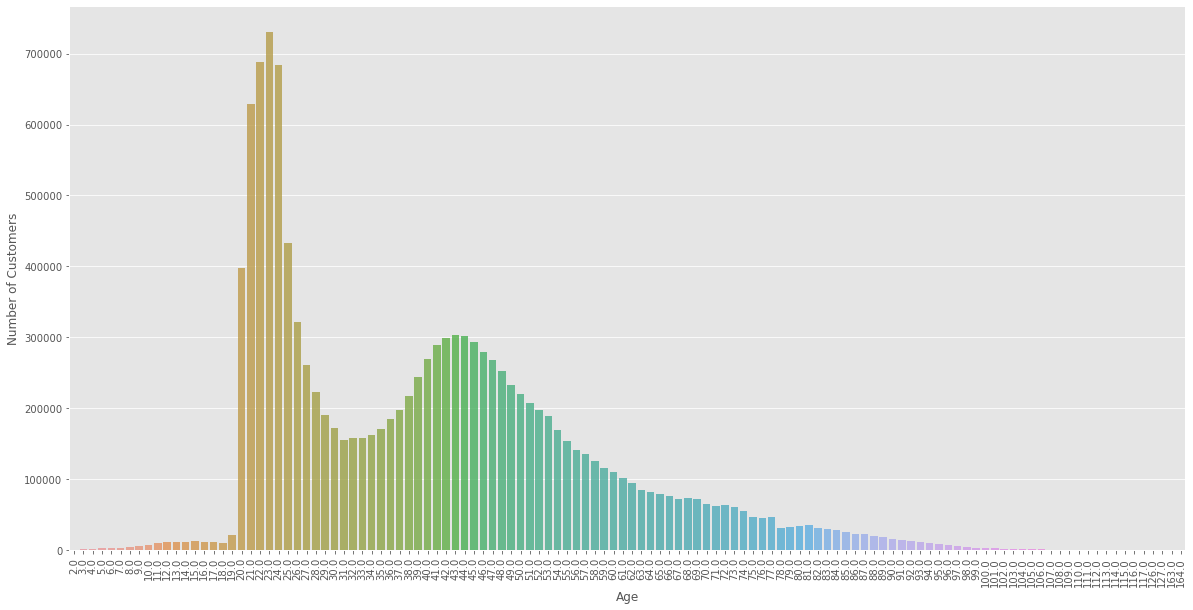

26088

In [4]:
sant_age = pd.read_csv("/kaggle/input/santander-pr/train.csv", usecols=['age'])

def string_num_age(x):
    if(type(x) == str and x != ' NA'):
        x = int(x)
    elif( x == ' NA'):
        x = np.nan
    return x

sant_age.age = sant_age.age.apply(lambda x: string_num_age(x))

plt.figure(figsize=(20,10))
sns.barplot(sant_age.age.value_counts().index, sant_age.age.value_counts().values, alpha=0.8)
plt.xlabel("Age")
plt.ylabel("Number of Customers")
plt.xticks(rotation="vertical")
plt.show()

del sant_age
gc.collect()

Since this is a bimodal distribution, it implies that there are two different groups of customers. \
Possible approach:\
Split the age into two groups, young and seniors

Changed the datatype of Age to string to prevent any implicit ordering. \
**Replace nan by certain value**

[What is bimodal](https://www.statisticshowto.com/what-is-a-bimodal-distribution/) \
[Dealing with bimodal - regression](https://www.quora.com/How-should-I-deal-with-bimodal-variables-in-a-regression-model)

**Looking at the test set distribution as well**

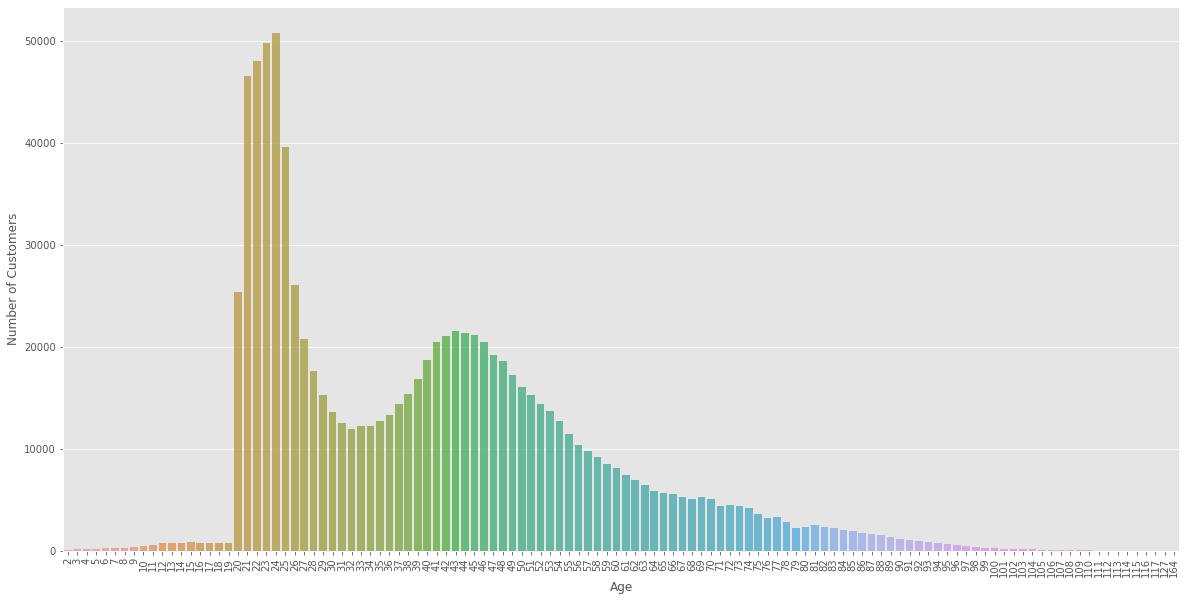

25555

In [5]:
test_age = pd.read_csv("/kaggle/input/santander-pr/test.csv", usecols=['age'])
test_age.age = test_age.age.apply(lambda x: string_num_age(x))
plt.figure(figsize=(20,10))
sns.barplot(test_age.age.value_counts().index, test_age.age.value_counts().values, alpha=0.8)
plt.xlabel("Age")
plt.ylabel("Number of Customers")
plt.xticks(rotation="vertical")
plt.show()

del test_age
gc.collect()

So we do have a similar distribution in the test split as well, hence no issue of covariate shift. 

## Sexo

H -> Female \
V -> Male\
Filling the null values with `V` though it would be better to predict what these null value should be. 

## Date Customer became first holder of contract And Recorded dates

> The terms and conditions of any banking contract will represent the legal foundations of how business will be conducted between the bank and the customer. Usually if a customer opens an account they will sign a contract and a bank’s representative will read through the contract with the customer. In most cases this will often occur as a quick scan of the contract with a signature required at the bottom of the contract.

[Banking Contracts](http://www.contractsandagreements.co.uk/banking.html)

Could maybe look at the time difference(in months) from this date i.e. first took a contract until the data. Could provide insights on which product to buy and which to drop.

[Dealing with DateTime](https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96)

In [6]:
dates = pd.read_csv("/kaggle/input/santander-pr/train.csv", usecols=['fecha_alta','fecha_dato'], parse_dates=['fecha_dato','fecha_alta'])

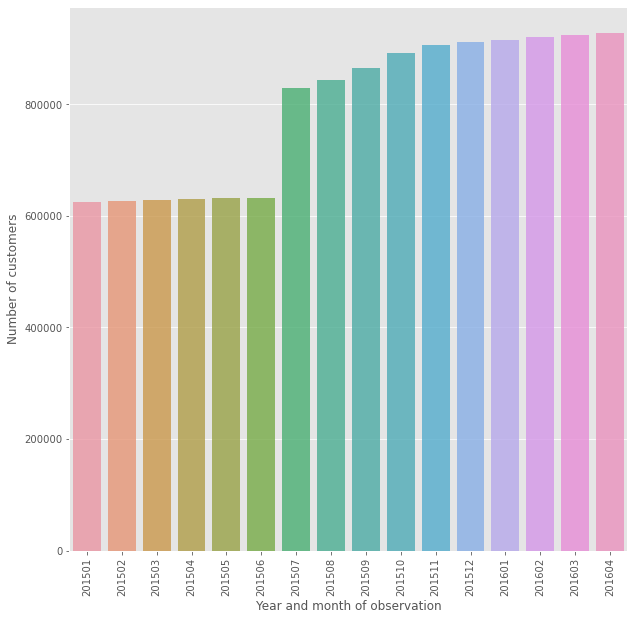

TypeError: set_xlabel() missing 1 required positional argument: 'xlabel'

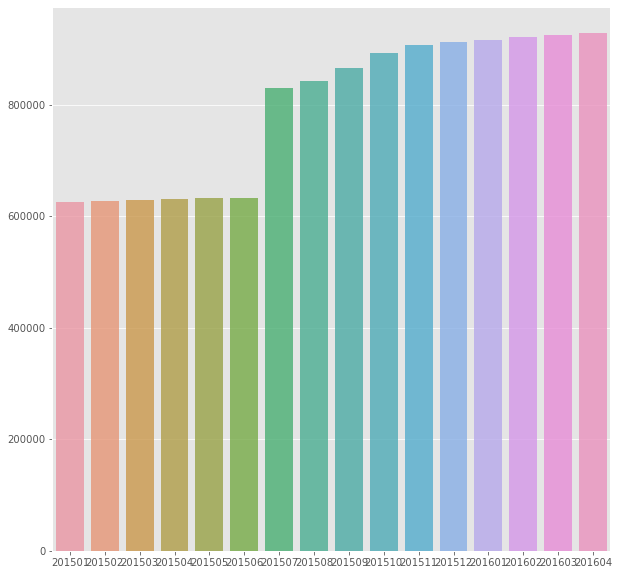

In [7]:
dates['dato_yearmonth'] = dates['fecha_dato'].apply(lambda x: 100*x.year + x.month)
num_of_cus = dates['dato_yearmonth'].value_counts()

plt.figure(figsize=[10,10])
sns.barplot(num_of_cus.index, num_of_cus.values, alpha=0.8)
plt.xlabel('Year and month of observation', fontsize=12)
plt.ylabel('Number of customers', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

fig, a = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
sns.barplot(num_of_cus.index, num_of_cus.values, alpha=0.8, ax=a)
a.set_xlabel()

In the later months the number of customers increased from 7-2015

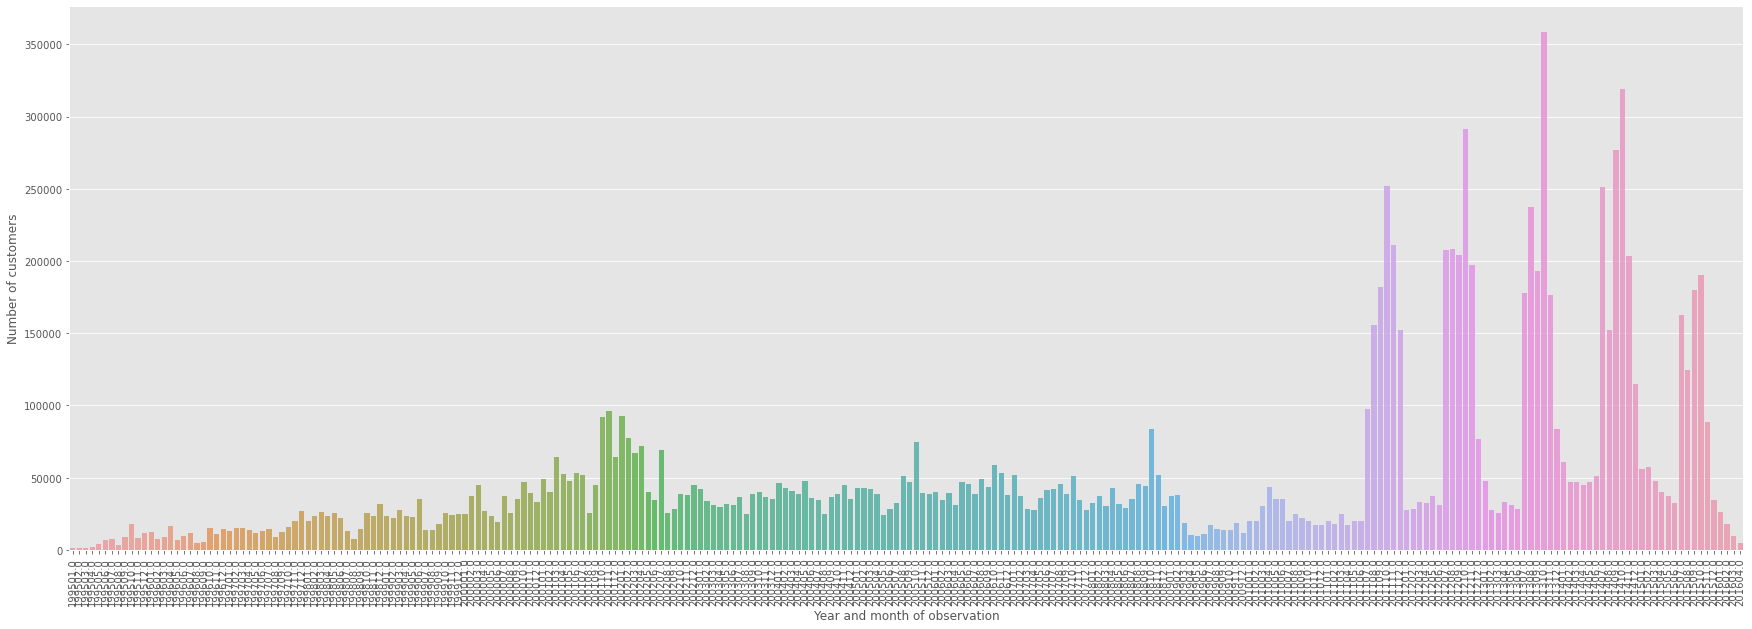

In [8]:
dates['alta_yearmonth'] = dates['fecha_alta'].apply(lambda x: 100*x.year + x.month)
num_of_cus = dates['alta_yearmonth'].value_counts()

plt.figure(figsize=[30,10])
sns.barplot(num_of_cus.index, num_of_cus.values, alpha=0.8)
plt.xlabel('Year and month of observation', fontsize=12)
plt.ylabel('Number of customers', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [9]:
print("Earliest Date: " + str(min(num_of_cus.index)))
print("Latest Date: " + str(max(num_of_cus.index)))

Earliest Date: 199501.0
Latest Date: 201604.0


In [10]:
num_of_cus = num_of_cus.sort_index().reset_index()
x = num_of_cus.loc[190:,:]
x.head()

,index,alta_yearmonth
190,201011.0,17236
191,201012.0,16980
192,201101.0,19737
193,201102.0,18072
194,201103.0,24750


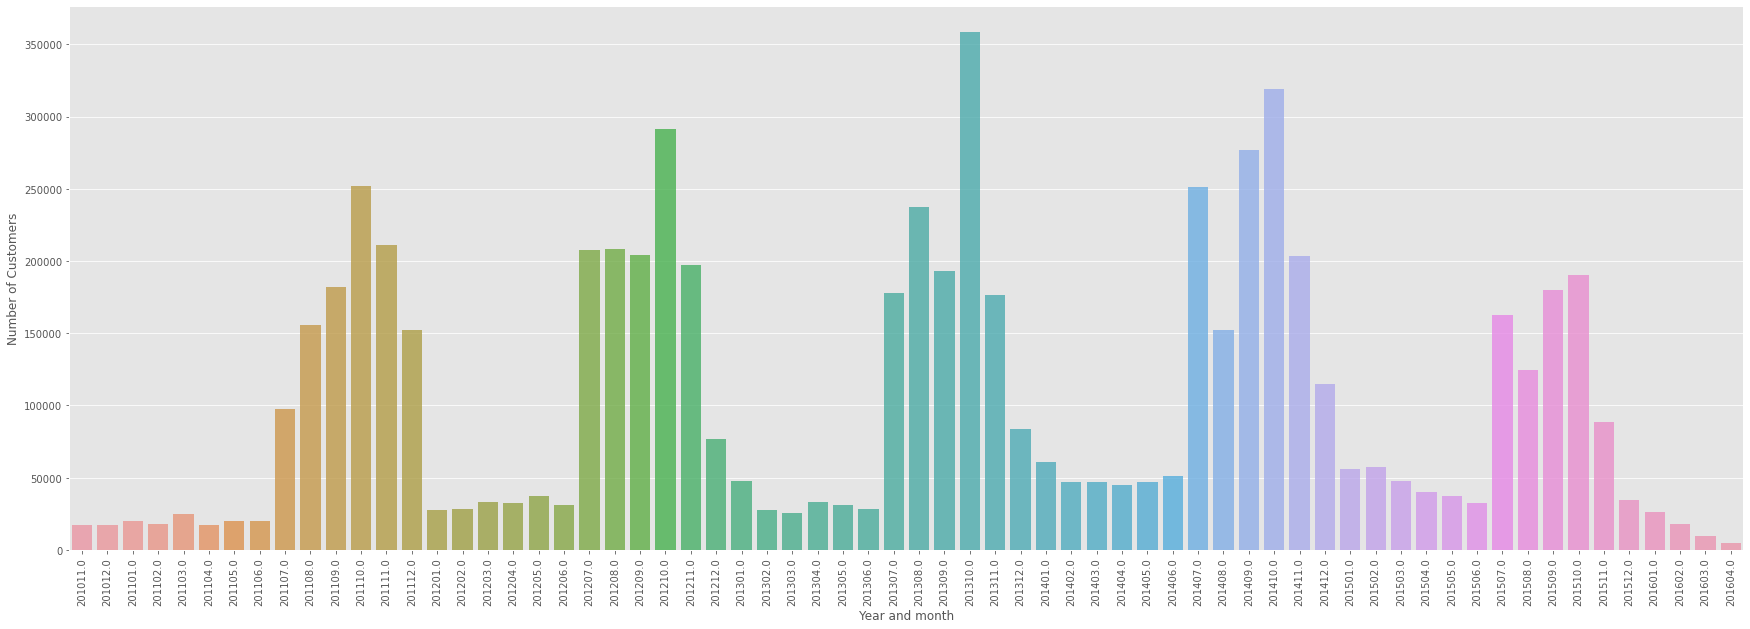

In [11]:
x.columns = ['yearmonth', 'customers']
plt.figure(figsize=(30,10))
sns.barplot(x.yearmonth, x.customers, alpha=0.8)
plt.xlabel('Year and month', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Sudden increase in number of customers becoming first holder of contracts in the later years. In that as well after looking at the peaks, we see that the number of customers are higher when it is the (7,8,9,10,11,12)th month. 

## Seniority of Customers
seniority of customers means: how long they have been a customer at the bank.

antiguedad    0
dtype: int64


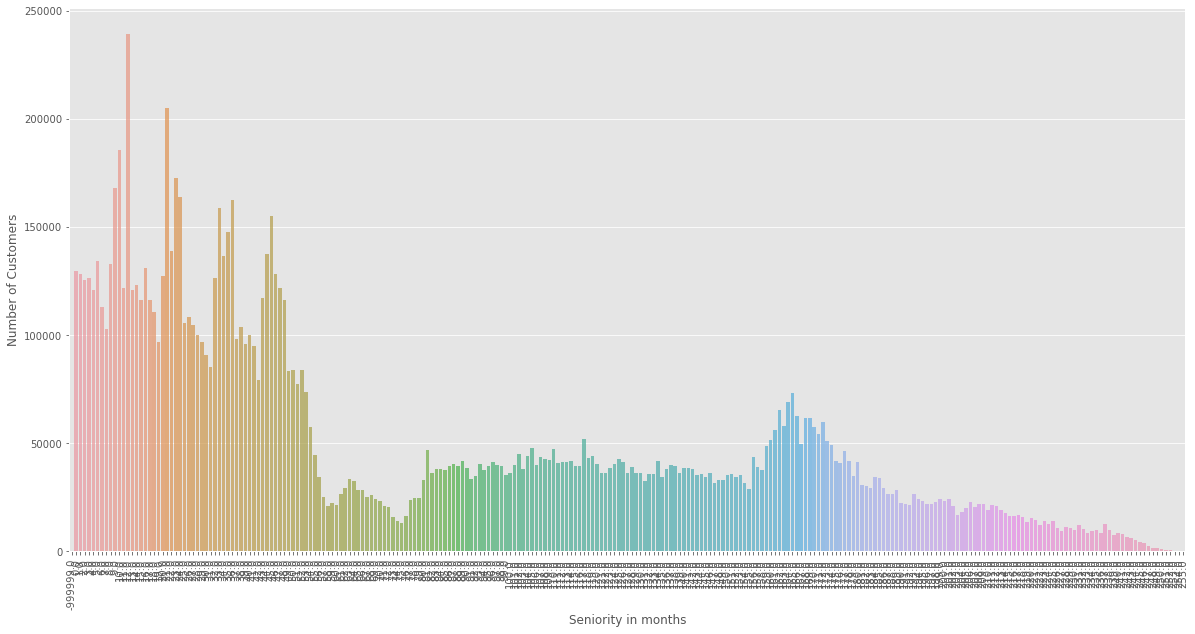

In [15]:
senior = pd.read_csv("/kaggle/input/santander-pr/train.csv", usecols=["antiguedad"])
print(senior.isnull().sum())

def string_num_senior(x):
    if(type(x) == str and x != '     NA'):
        x = int(x)
    elif( x == '     NA'):
        x = np.nan
    return x

senior["antiguedad"] = senior.antiguedad.apply(lambda x: string_num_senior(x))

plt.figure(figsize=(20,10))
sns.barplot(senior.antiguedad.value_counts().index, senior.antiguedad.value_counts().values, alpha=0.7)
plt.xlabel('Seniority in months')
plt.ylabel('Number of Customers')
plt.xticks(rotation='vertical')
plt.show()

In [16]:
senior_time = pd.read_csv("/kaggle/input/santander-pr/train.csv", usecols=["antiguedad","ind_nuevo"])

In [17]:
senior_time["ind_nuevo"] = senior_time["ind_nuevo"].fillna(value=1)
senior_time["ind_nuevo"], _ = reduce_mem_usage(senior_time["ind_nuevo"], senior_time)

Memory usage of properties dataframe is : 194.0286865234375  MB
******************************
Column:  0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
           ... 
12715851    0.0
12715852    0.0
12715853    0.0
12715854    0.0
12715855    0.0
Name: ind_nuevo, Length: 12715856, dtype: float64
dtype before:  float64
dtype after:  uint8
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  194.0286865234375  MB
This is  100.0 % of the initial size


In [18]:
senior_time["antiguedad"] = senior_time.antiguedad.apply(lambda x: string_num_senior(x))
print(senior_time["antiguedad"].isnull().sum())
senior_time["antiguedad"].fillna(value=-99998, inplace=True)

27734


In [19]:
x = senior_time[((senior_time["antiguedad"] >= 6) & (senior_time["ind_nuevo"] == 1)) | ((senior_time["antiguedad"] <= 5) & (senior_time["ind_nuevo"] == 0))].copy(deep=True) # SHould ideally be empty, except -9999 readings
x["antiguedad"].value_counts()

 6.0         11834
-999999.0       35
Name: antiguedad, dtype: int64

In [20]:
x = senior_time.groupby("antiguedad").get_group(-999999.0)
x.ind_nuevo.unique()

array([0], dtype=uint8)

1 -> <=5, 0 -> >=6 \
Some discrepancy: Among the values for 6 -> out of 113155, 11834 are opposite of expected, i.e. 1. According to definition, a cutomer is considered new if he joined in the past 6 months. Given that 10% of data is opposing this. Changing it back to the expected one could be right. 
Also the hypothesis was right, the seniority of a customer does represent how long ago the customer joined. 

Further, the unique 35 values of -9999 have the ind_nuevo values as 0. So we can probably give it some value greater than 6, or delete these records, though the later doesn't seem favourable.Make sure to make similar change in the **test set** as well\
Also all the null values have the ind_nuevo value as 1, which means we can fill those values by any value from [1,5].

> Calculate the accuracy while keeping the erroneous values corresponding to 6 same, and in another case, change it to what the expected value is and see which gives better accuracy.  

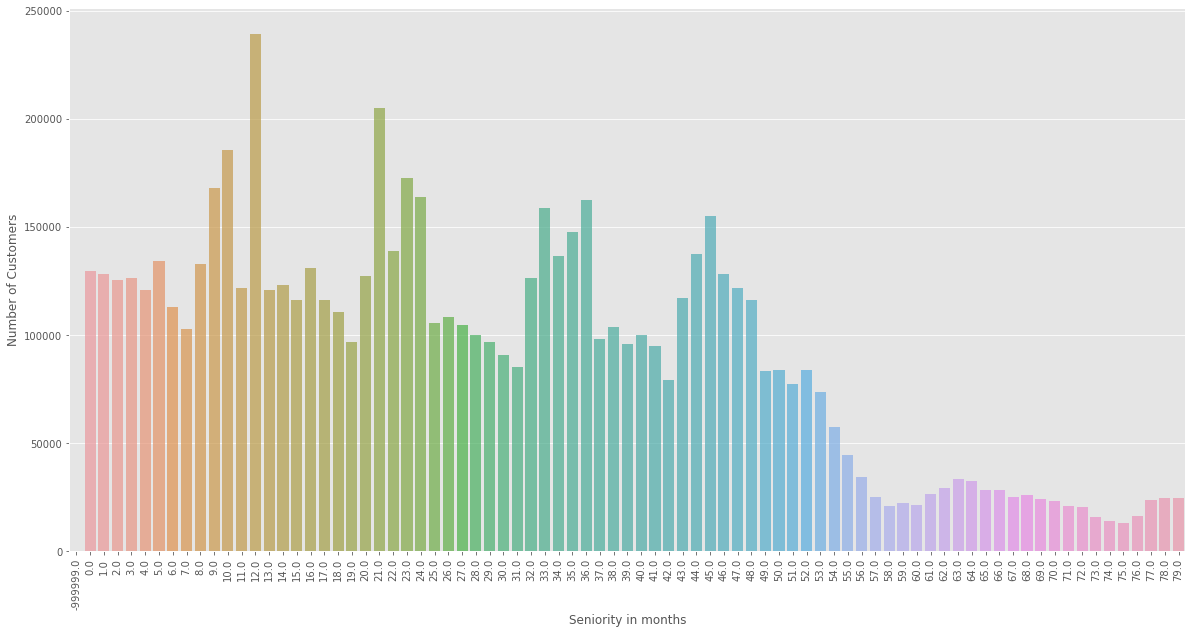

In [21]:
x = senior.groupby("antiguedad").size().reset_index()

x.columns = ['Seniority','Number of Customers']

x = x.loc[:80]
plt.figure(figsize=(20,10))
sns.barplot(x.Seniority ,x["Number of Customers"], alpha=0.7)
plt.xlabel('Seniority in months')
plt.ylabel('Number of Customers')
plt.xticks(rotation='vertical')
plt.show()

There is no very distinct peak but among the ones present, they do bring forth certain patterns. So, we are counting the seniority from 5-2016. So, if we look at the barplot, we see high number of customers with seniority [12,24,36,48] and the nearby values for each of them. This shows that near the middle of the year, there is a huge inflow of customers at the bank, but only for the past 4 years. beyond that, the values don't show much of the same pattern.

## Primary Customer

| feature | Description |
| ----| ----|
|indrel	|1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)|
|ult_fec_cli_1t	|Last date as primary customer (if he isn't at the end of the month)|
|indrel_1mes	|Customer type at the beginning of the month ,1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner)|

In [22]:
primary = pd.read_csv("/kaggle/input/santander-pr/train.csv", usecols=["ncodpers","indrel","ult_fec_cli_1t","indrel_1mes"])

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


So, 1 if a customer is a primary customer, 99 if the customer is no longer a primary customer( if he loses the primary status at any time of the month he is given 99 for that month)

Last date as primary customer: This column can be removed, it is filled with NaN, 99.8% of the values are null. Hence dumping this column.

In [23]:
primary.indrel_1mes.isnull().sum()

145771

In [24]:
import math

def string_num_primary(x):
    if(type(x) == int and x!= np.nan):
        x = int(x)
        x = str(x)
    elif(type(x) == float and math.isnan(x)==False):
        x = int(x)
        x = str(x)
    elif(type(x) == float and math.isnan(x)):
        x = "NA"
    return x

def fti_string(x):
    if(type(x) == str and x != 'NA'):
        if(x.find(".") != -1):
            t = float(x)
            t = int(t)
            x = str(t)
    return x

primary["indrel_1mes"] = primary["indrel_1mes"].apply(lambda x: string_num_primary(x))
primary["indrel_1mes"] = primary["indrel_1mes"].apply(lambda x: fti_string(x))

In [25]:
primary.indrel_1mes.unique()

array(['1', 'NA', '3', '2', '4', 'P'], dtype=object)

So, this column has high chances of being redundant, since the only extra information it provides is of the people under the 99 category of indrel. 
For the values for which the indrel is 1, the value of indrel_1mes will be, 1. 

In [26]:
primary.indrel_1mes.value_counts()

1     12563767
NA      145771
3         4045
2         1195
P          797
4          281
Name: indrel_1mes, dtype: int64

In [27]:
primary.indrel.isnull().sum()

27734

In [28]:
## ToDo
## Set an index column -> make an array of len(primary.shape[0]) and use .set_index to make that column the index.
primary["index"] = np.array(range(primary.shape[0]))
primary.set_index('index')
## See the null values of indrel -> if corresponding values in the indrel_1mes are nonnull, replace by the required value
ind = primary[primary["indrel"].isnull()].copy(deep=True)
ind_subset = ind[ind["indrel_1mes"] != 'NA'].copy(deep=True)

# for i in ind_subset.index:
#     x = primary.iloc[i]
#     if(x.indrel_1mes == '1'):
#         print(1)
#         primary.iloc[i].indrel = 1
#     else:
#         primary.iloc[i].indrel = 99

In [29]:
ind = primary[primary["indrel"].isnull() == False].copy(deep=True)
ind_subset = ind[ind["indrel_1mes"] == 'NA'].copy(deep=True)

# for i in ind_subset.index:
#     x = primary.iloc[i]
#     if(x.indrel == 1):
#         primary.iloc[i, primary.columns.get_loc('indrel_1mes')] = 1
        

In [30]:
del primary
del ind
del ind_subset
del x
gc.collect()

140636

## Remaining Variables

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


tiprel_1mes                145771
indresi                     27734
indext                      27734
conyuemp                 12714162
canal_entrada              179427
indfall                     27734
tipodom                     27735
cod_prov                    89599
nomprov                     89599
ind_actividad_cliente       27734
segmento                   182343
dtype: int64


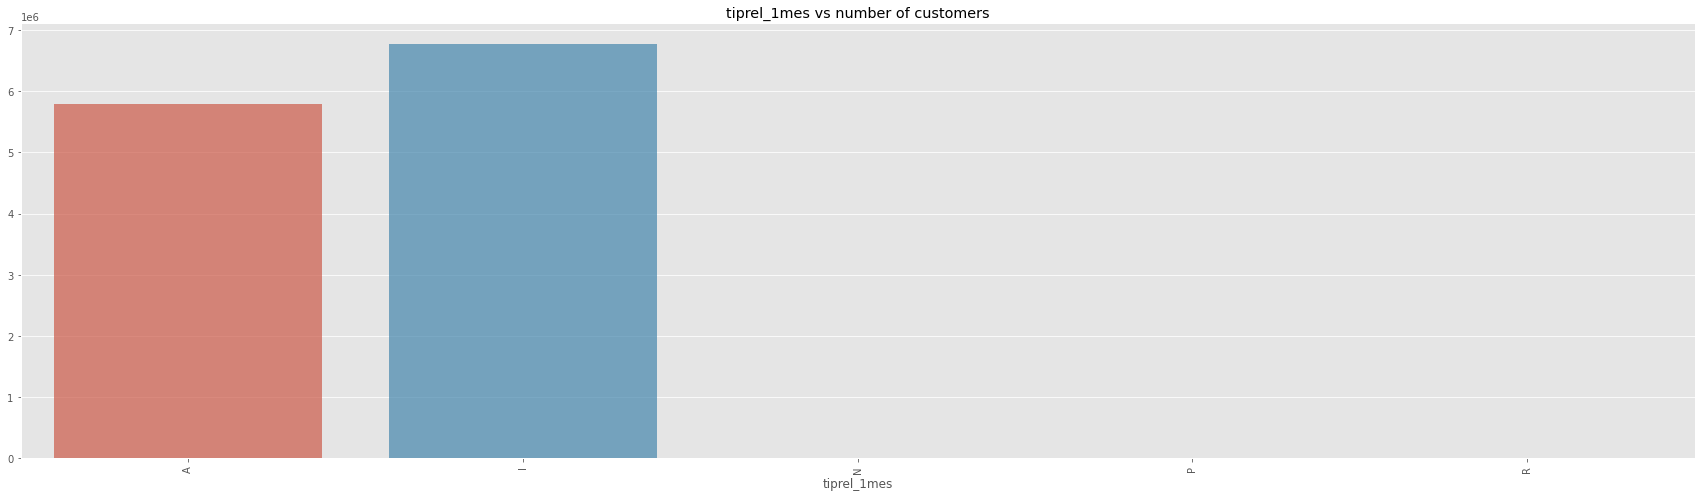

All values are:
I    6770446
A    5794516
P       4326
R        793
N          4
Name: tiprel_1mes, dtype: int64
Null : 145771


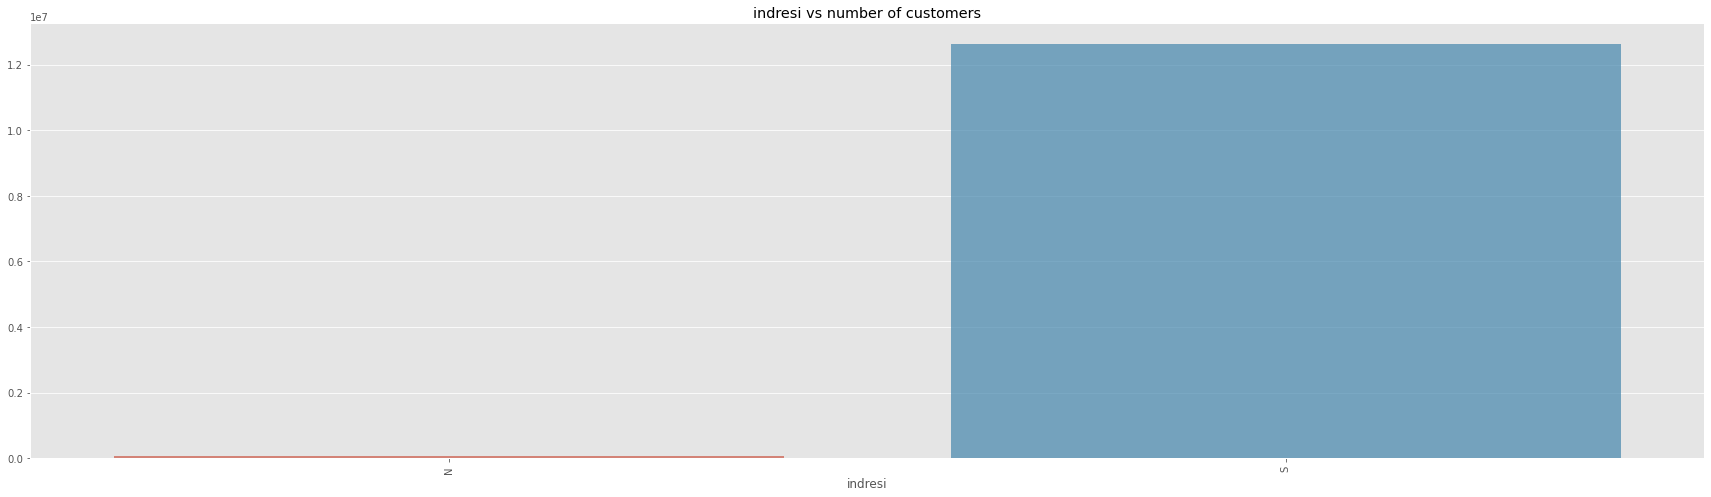

All values are:
S    12626250
N       61872
Name: indresi, dtype: int64
Null : 27734


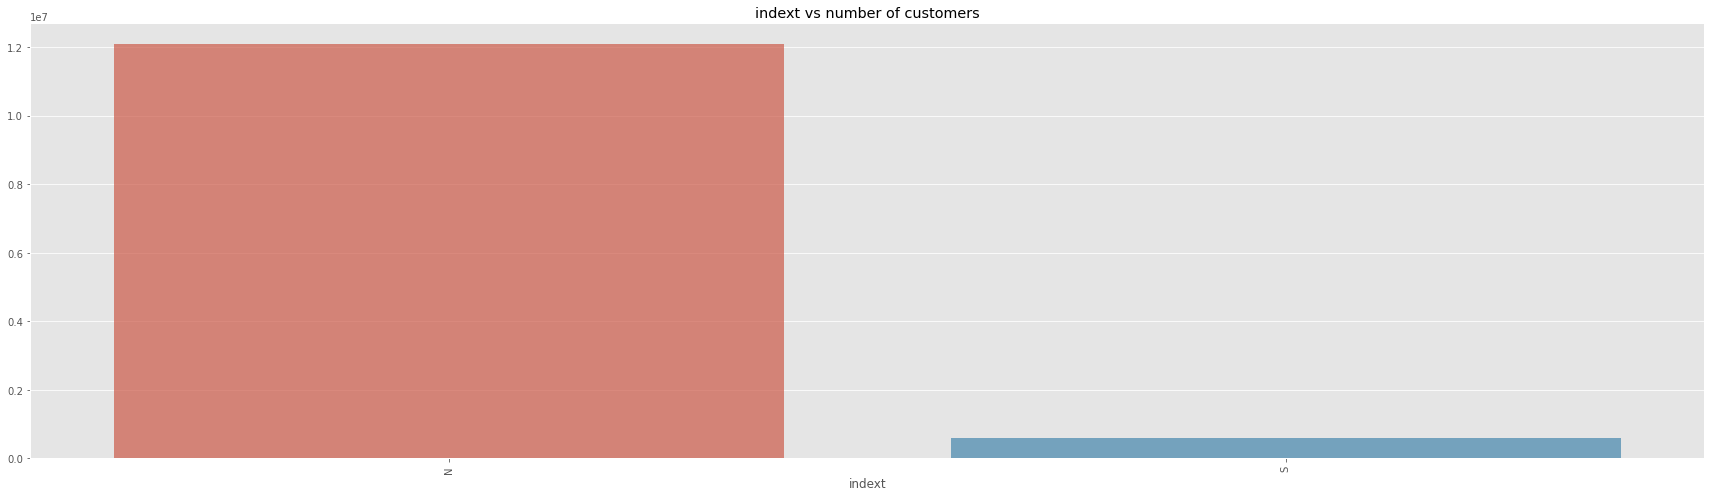

All values are:
N    12089626
S      598496
Name: indext, dtype: int64
Null : 27734


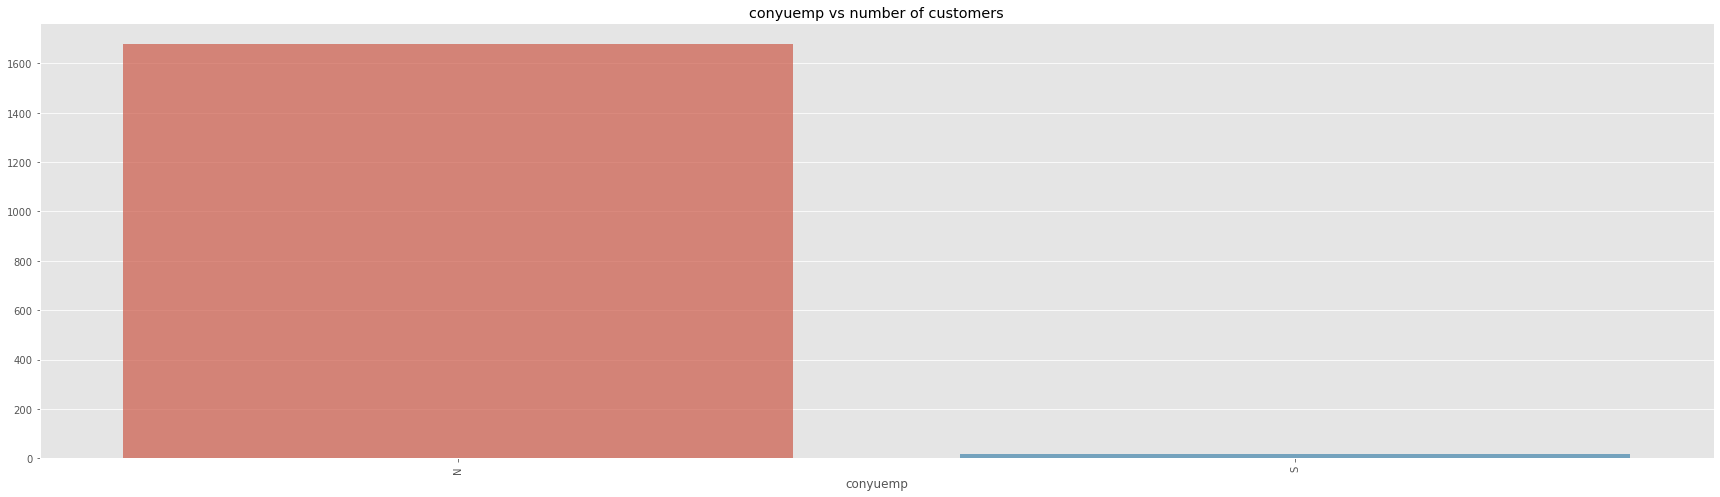

All values are:
N    1678
S      16
Name: conyuemp, dtype: int64
Null : 12714162


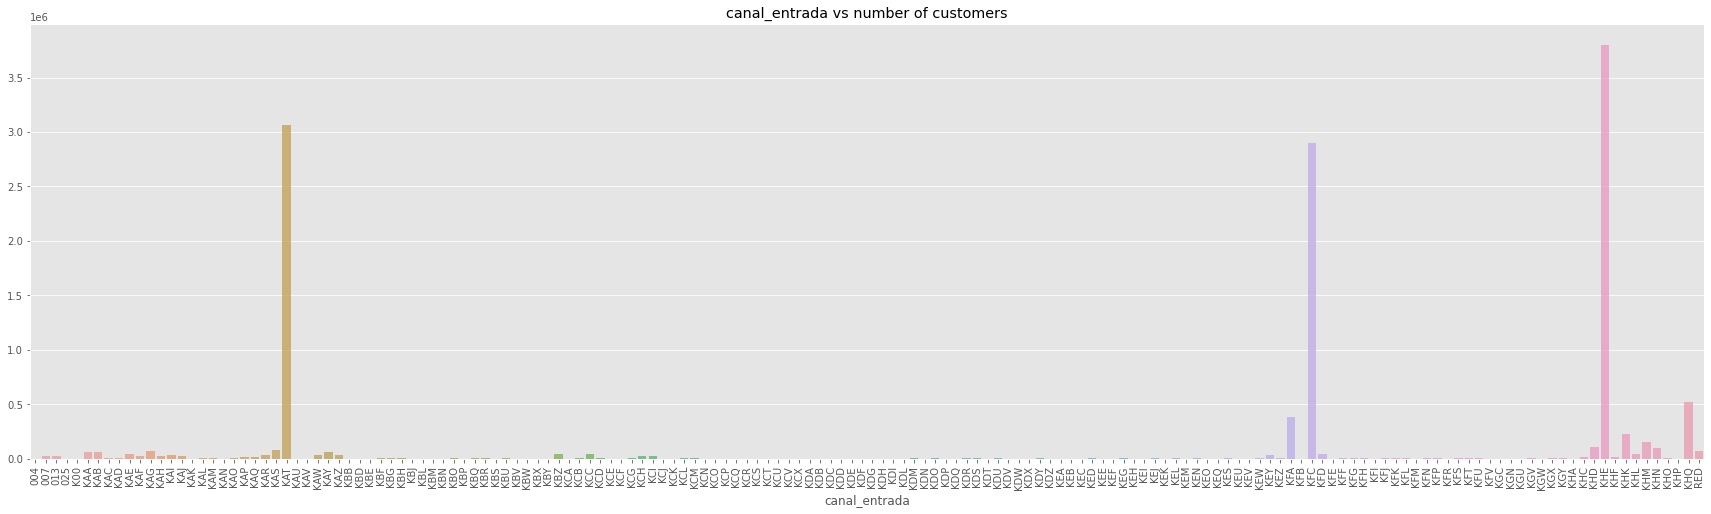

All values are:
KHE    3803466
KAT    3062121
KFC    2897468
KHQ     515966
KFA     383963
        ...   
KDB         16
KDI         16
KGN         16
025         10
KDL         10
Name: canal_entrada, Length: 160, dtype: int64
Null : 179427


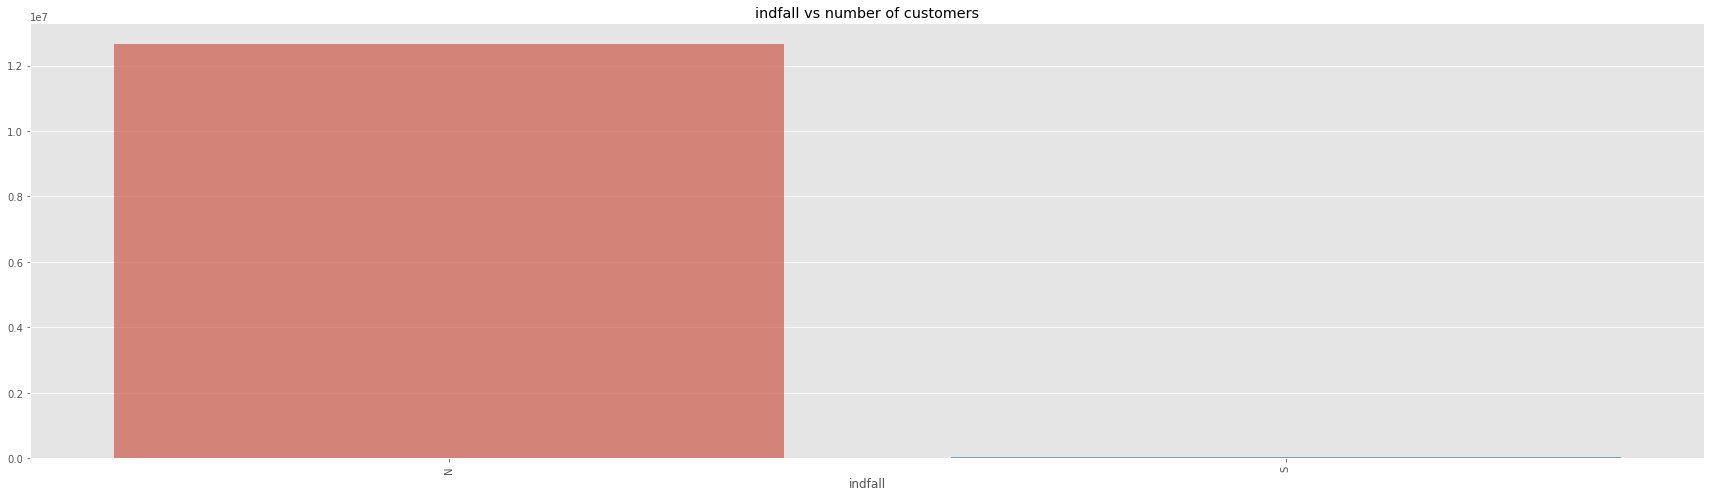

All values are:
N    12655726
S       32396
Name: indfall, dtype: int64
Null : 27734


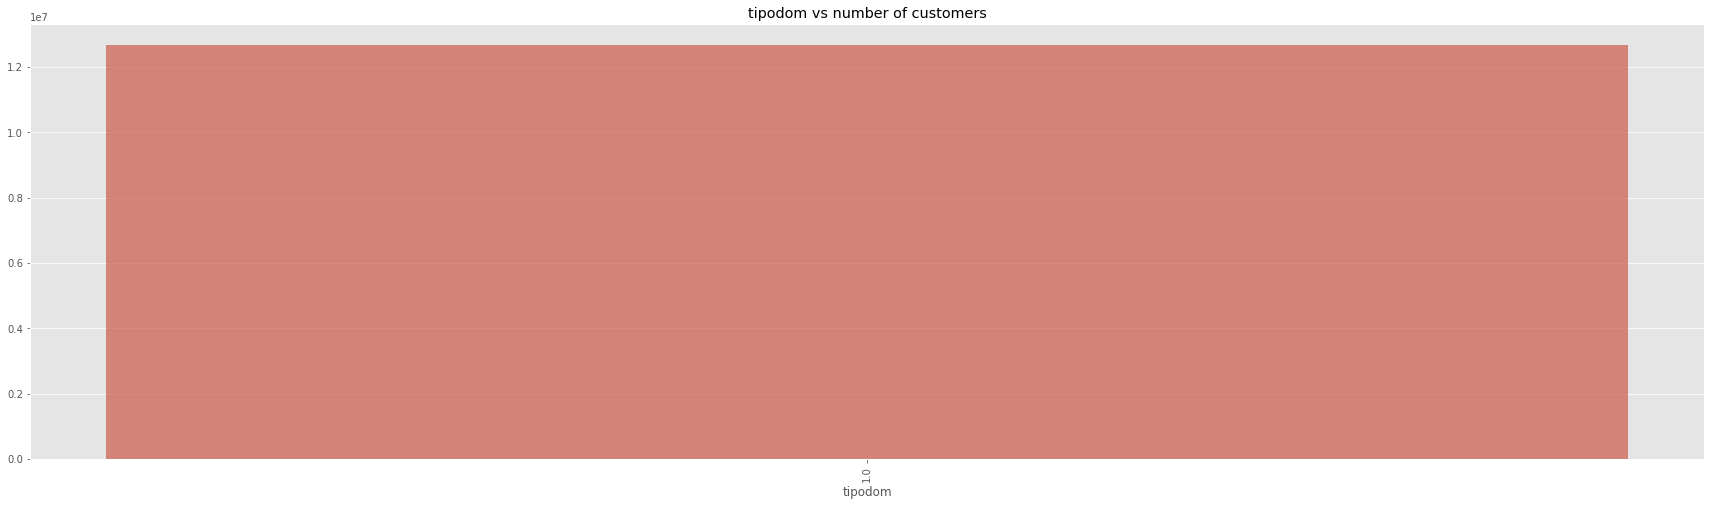

All values are:
1.0    12688121
Name: tipodom, dtype: int64
Null : 27735


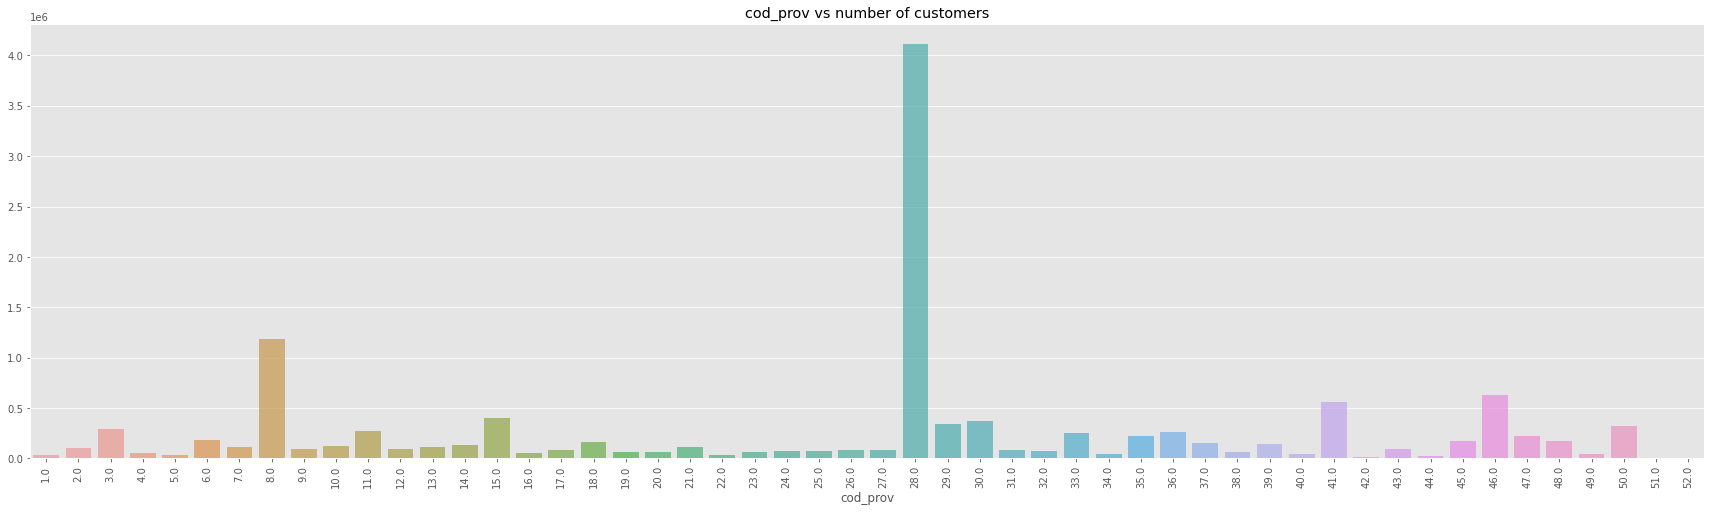

All values are:
28.0    4110759
8.0     1186465
46.0     634201
41.0     564583
15.0     400551
30.0     368964
29.0     342440
50.0     319345
3.0      291187
11.0     274855
36.0     261036
33.0     247417
47.0     222215
35.0     219339
6.0      180047
48.0     173360
45.0     170377
18.0     166136
37.0     153145
39.0     144863
14.0     134822
10.0     121307
7.0      115790
21.0     114251
13.0     111294
2.0      106336
12.0      97127
43.0      92465
9.0       90528
17.0      84225
31.0      82595
26.0      79386
27.0      79292
32.0      78394
24.0      77272
25.0      73620
20.0      66680
38.0      65849
19.0      59923
23.0      59854
4.0       55974
16.0      53517
49.0      47494
34.0      45963
40.0      39460
22.0      37386
5.0       36151
1.0       35107
44.0      20987
42.0      16399
52.0       8819
51.0       6705
Name: cod_prov, dtype: int64
Null : 89599


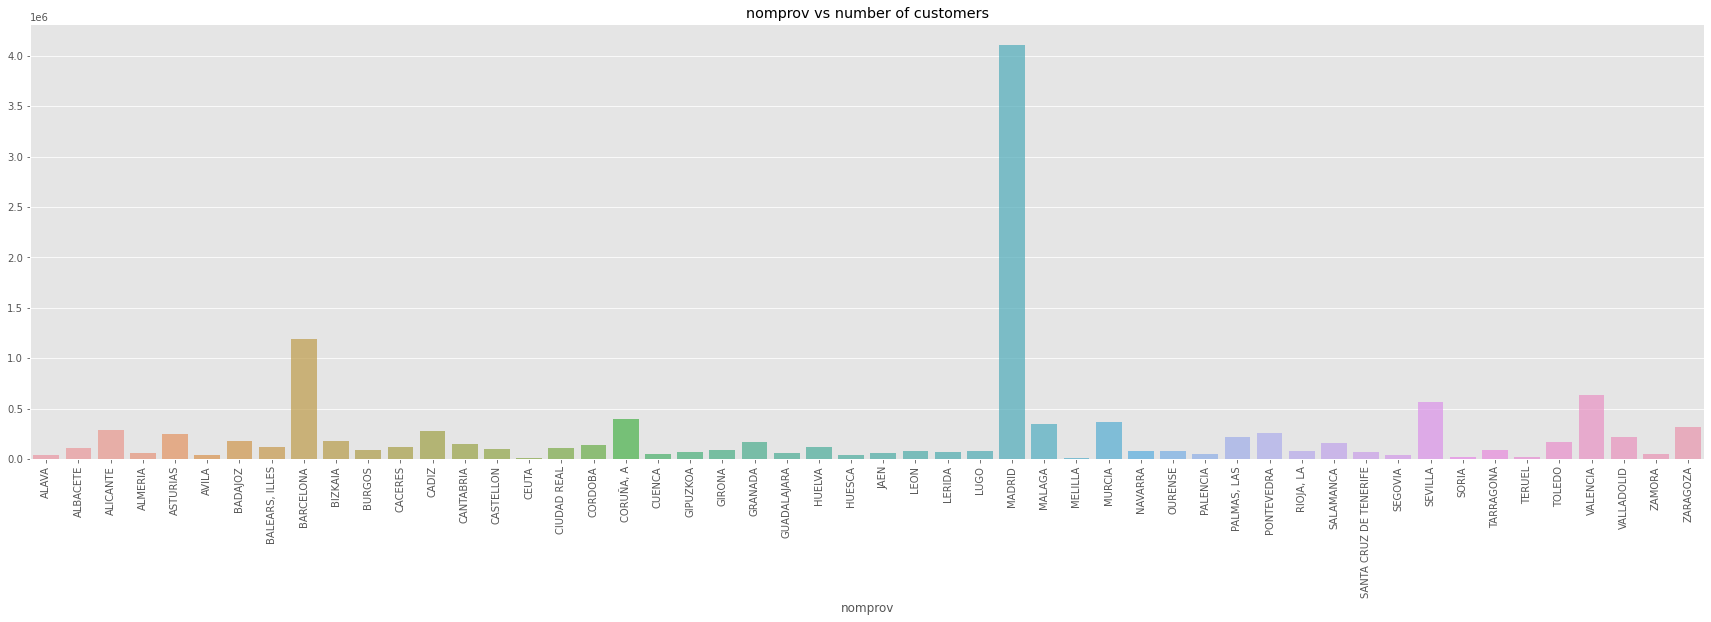

All values are:
MADRID                    4110759
BARCELONA                 1186465
VALENCIA                   634201
SEVILLA                    564583
CORUÑA, A                  400551
MURCIA                     368964
MALAGA                     342440
ZARAGOZA                   319345
ALICANTE                   291187
CADIZ                      274855
PONTEVEDRA                 261036
ASTURIAS                   247417
VALLADOLID                 222215
PALMAS, LAS                219339
BADAJOZ                    180047
BIZKAIA                    173360
TOLEDO                     170377
GRANADA                    166136
SALAMANCA                  153145
CANTABRIA                  144863
CORDOBA                    134822
CACERES                    121307
BALEARS, ILLES             115790
HUELVA                     114251
CIUDAD REAL                111294
ALBACETE                   106336
CASTELLON                   97127
TARRAGONA                   92465
BURGOS                      9052

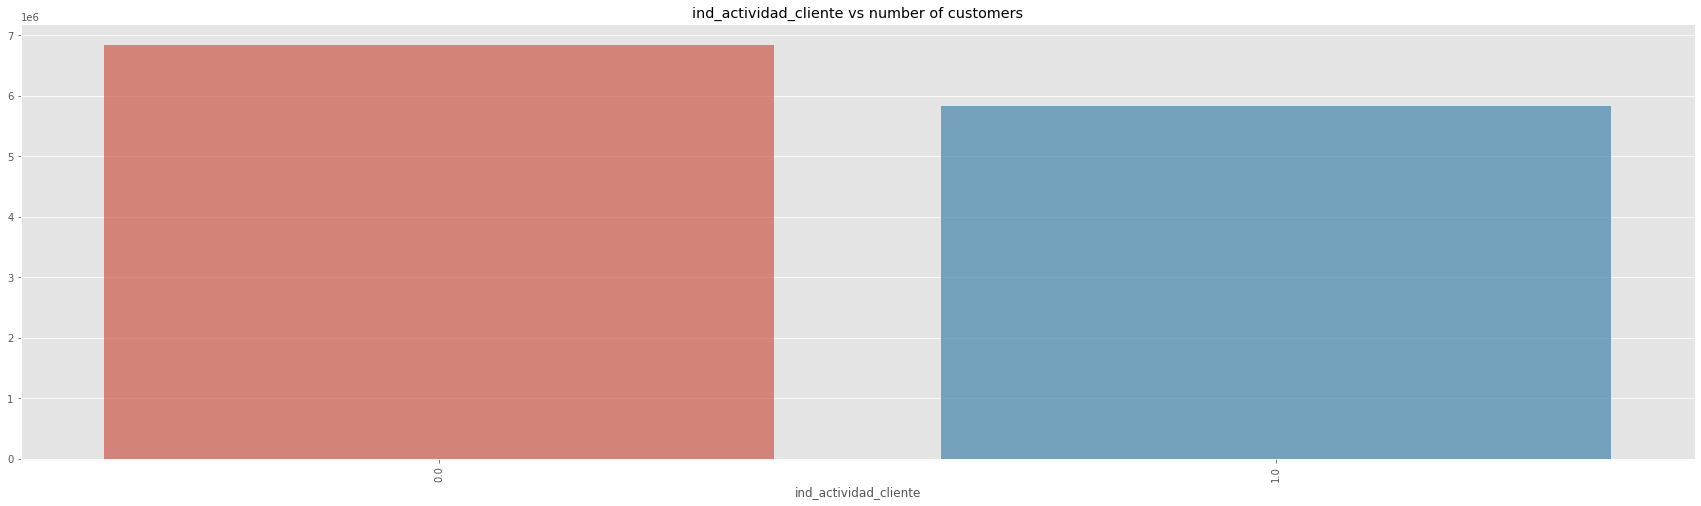

All values are:
0.0    6848660
1.0    5839462
Name: ind_actividad_cliente, dtype: int64
Null : 27734


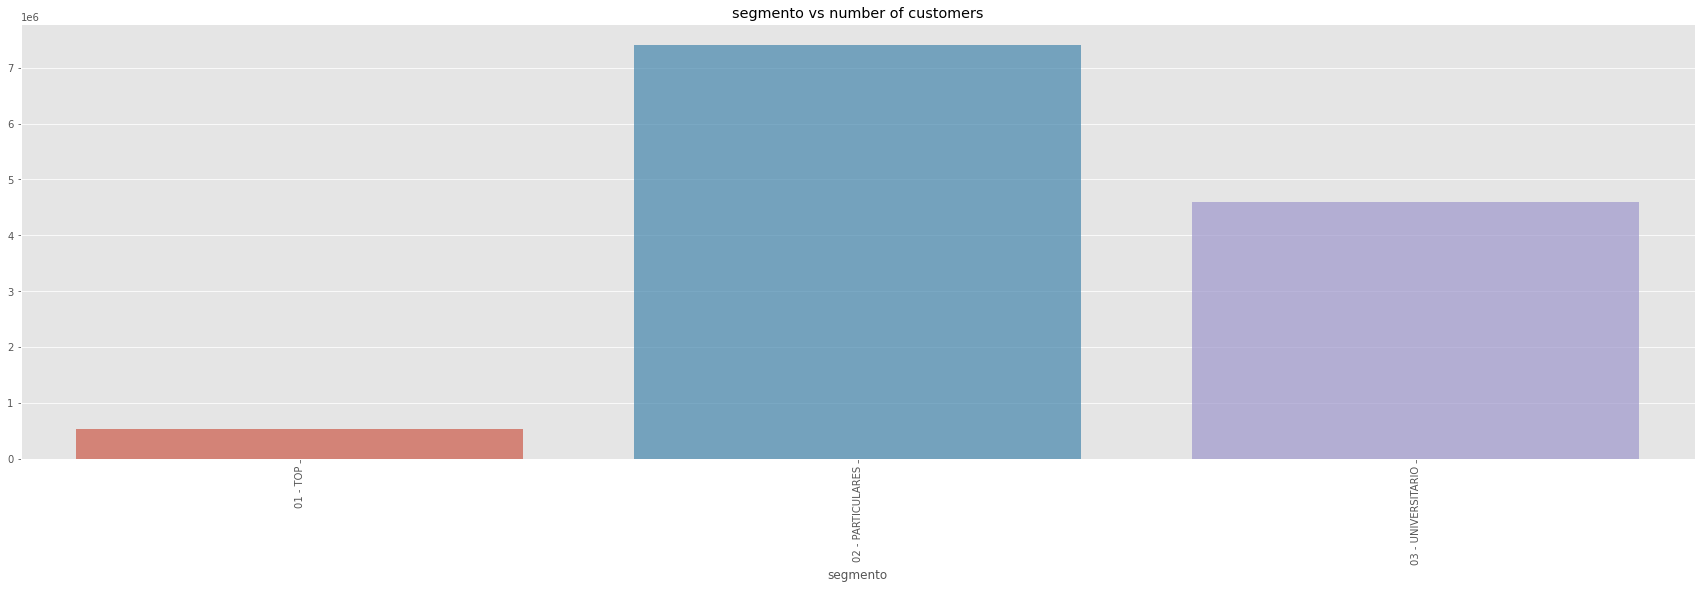

All values are:
02 - PARTICULARES     7417624
03 - UNIVERSITARIO    4589162
01 - TOP               526727
Name: segmento, dtype: int64
Null : 182343


In [31]:
relation = pd.read_csv('/kaggle/input/santander-pr/train.csv', usecols=['tiprel_1mes', 'indresi', 'indext','conyuemp','canal_entrada','indfall','tipodom','cod_prov', 'nomprov','ind_actividad_cliente', 'segmento'])

print(relation.isnull().sum())
for i in relation.columns:
    plt.figure(figsize=(30,8))
    a = sns.barplot(relation.groupby(i).size().index, relation.groupby(i).size().values, alpha=0.7)
    plt.xticks(rotation='vertical')
    plt.title(i + " vs number of customers")
    plt.show()
    print("All values are:\n" + str(relation[i].value_counts()))
    print("Null : " + str(relation[i].isnull().sum()))

## tiprel_1mes -> Customer Relation

Most of the customers are either Active `A` or Inactive `I`. The customers belonging to `P` and `R` are negligible along with the category `N` which has only 5 values? And a large portion of it is null - `145771`

## indresi -> Residence Index

This is one of the categories which has 27734 null values. Most of the customers are Resident of the country. So a safe option is to fill the null values with `S`. 


## canal_entrada -> Channel used to join

We can fill the null values with KHE for now given that they are the maximum occuring values. Later, we could use other methods of filling these missing values (build a model)


## ind_actividad_cliente -> activity index

Good enough distribution amongst both of the categories. Safe bet to fill in the null values with 0, since there are higher number of inactive customers. Initially won't encode it, well it appears like giving a sense of ordering will be kind of better? 

## renta -> Income

In [32]:
df = pd.read_csv("/kaggle/input/santander-pr/train.csv", usecols=['renta', 'age', 'sexo','segmento', 'ind_plan_fin_ult1', 'ind_nom_pens_ult1','ind_ctju_fin_ult1'])

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


One approach of fillinf the incomes. Later changed.

In [33]:
import random

def string_num_age(x):
    if(type(x) == str and x != ' NA'):
        x = int(x)
    elif( x == ' NA'):
        x = np.nan
    return x

df.age = df.age.apply(lambda x: string_num_age(x))
df.age = np.where(((df.ind_plan_fin_ult1==1) & (df.age.isnull())) | ((df.ind_nom_pens_ult1 == 1) & (df.age.isnull())), 45, df.age)
df.age = np.where((df.segmento=="03 - UNIVERSITARIO") & (df.age.isnull()),24, df.age)
df.age = np.where((df.ind_ctju_fin_ult1 == 1) & (df.age.isnull()),14, df.age)
df.age = np.where(df.age < 14, 14, df.age)
df.age = np.where(df.age > 90, 90, df.age)
df.age = df.age.fillna(value=40)

df.segmento = np.where((df.segmento.isnull() & (df.age <= 33) & (df.age >= 20)),"03 - UNIVERSITARIO",df.segmento)
df.segmento = np.where((df.segmento.isnull() & ((df.age > 33) |(df.age <20))),"02 - PARTICULARES",df.segmento)

df.sexo = np.where(df.sexo.isnull(), random.choice(["V","H"]),df.sexo)

In [34]:
df.isnull().sum()

sexo                       0
age                        0
renta                2565357
segmento                   0
ind_ctju_fin_ult1          0
ind_plan_fin_ult1          0
ind_nom_pens_ult1      16063
dtype: int64

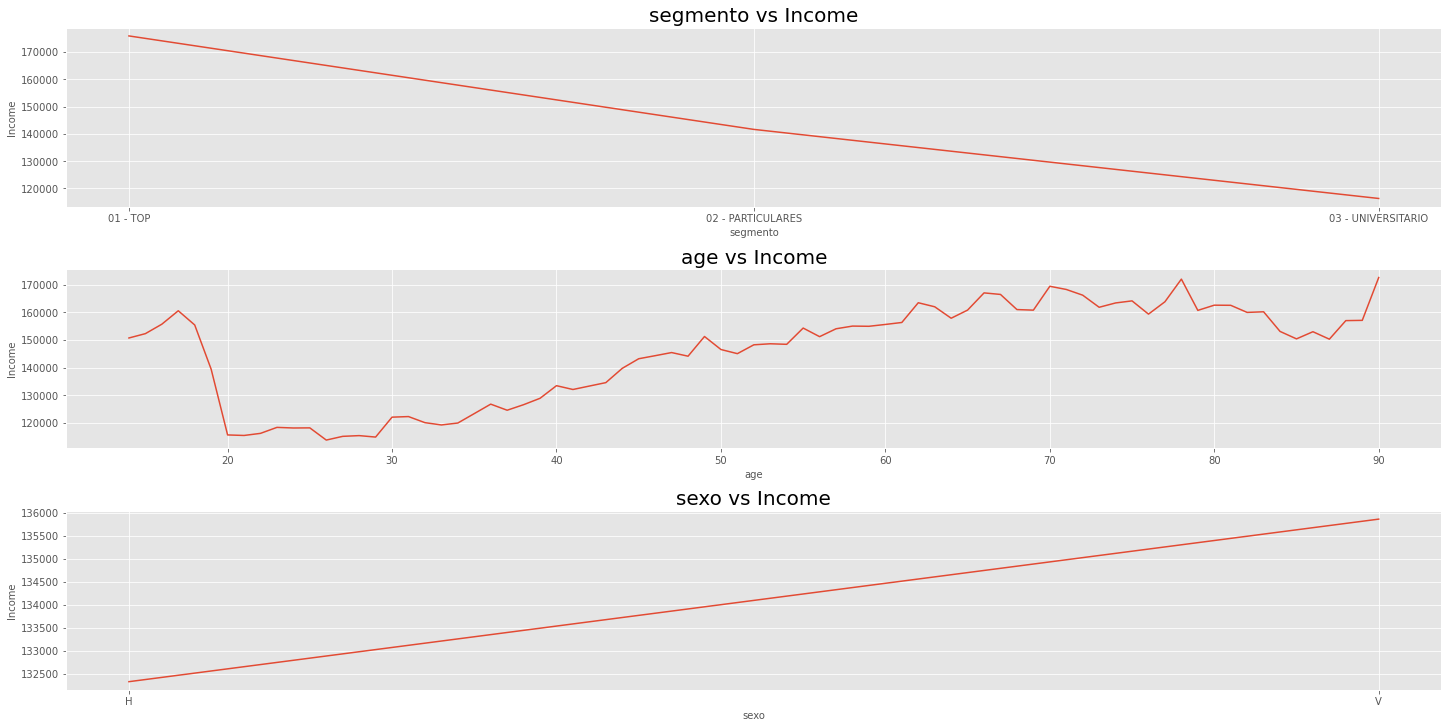

In [35]:
fig, a = plt.subplots(nrows=3,ncols=1, figsize=(20,10), constrained_layout=True)
var = ["segmento","age","sexo"]
r,c=0,0
for i in var:
    a[r].plot(df.groupby(i)["renta"].mean())
    a[r].set_title(i + " vs Income", fontsize=20)
    a[r].set_xlabel(i, fontsize=10)
    a[r].set_ylabel("Income", fontsize=10)
    a[r].tick_params(axis='x',labelsize=10, labelrotation=0)
    a[r].tick_params(axis='y',labelsize=10)
    r+=1

----------------------------------------

# Dealing with NULL values(Initial Approach)

## Age, indfall(FILLED)
Look at segmento
- VIP will not generally be young people
- College students will be greater than 18 less than 30 

Look at certain products, such as junior account \
Average Retirement age in 2015 was 65. `ind_plan_fin_ult1` and `ind_nom_pens_ult1` (pensions) for these people shall be 1 
- Average age of people who have this product is 45. Hence replacing such values by 45.

Less chances of College students taking `ind_aval_fin_ult1` (Bank Guarantees) (Rather bank agreeing to it, owing to lack of financial stability)

VIP + individuals more likely to hold `ind_cco_fin_ult1` (Current Accounts)

VIP + individuals likely to have `ind_cder_fin_ult1` (Directly Accounts)

VIP + individuals `ind_cno_fin_ult1` (Payroll Accounts) Pay the employees from this account

Under the age of 18 `ind_ctju_fin_ult1` (Junior Accounts) [Santander Guidelines](https://www.santander.co.uk/personal/current-accounts/123-mini-current-account)

`ind_ctma_fin_ult1` `ind_ctop_fin_ult1` `ind_ctpp_fin_ult1` (Mas Particulares, Particulares, Particulares Plus Accounts)

College graduates would be using `ind_reca_fin_ult1` (taxes)

For filling the remaining values which have `segmento` as `03 - UNIVERSITARIO`, we put in 24. (Mean ~ Median) **Look at it later, first fill up Segmento then fill the ages**

**Out of 121716 customers, 121468 customers have junior accounts** Those having Junior accounts can be filled with the age 14

In [37]:
CAge = pd.read_csv("/kaggle/input/santander-pr/train.csv", usecols=["ind_ahor_fin_ult1","ind_aval_fin_ult1","ind_cco_fin_ult1","ind_cder_fin_ult1","ind_cno_fin_ult1","ind_ctju_fin_ult1","ind_ctma_fin_ult1",
                                                                     "ind_ctop_fin_ult1","ind_ctpp_fin_ult1","ind_deco_fin_ult1","ind_deme_fin_ult1","ind_dela_fin_ult1", "ind_ecue_fin_ult1","ind_fond_fin_ult1",
                                                                     "ind_hip_fin_ult1", "ind_plan_fin_ult1","ind_pres_fin_ult1","ind_reca_fin_ult1","ind_tjcr_fin_ult1","ind_valo_fin_ult1","ind_viv_fin_ult1",
                                                                     "ind_nomina_ult1","ind_nom_pens_ult1","ind_recibo_ult1", "indfall", "segmento","age"])

def string_num_age(x):
    if(type(x) == str and x != ' NA'):
        x = int(x)
    elif( x == ' NA'):
        x = np.nan
    return x

CAge.age = CAge.age.apply(lambda x: string_num_age(x))

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
##################THIS IS THE FILLING################
# CAge.age = np.where(((CAge.ind_plan_fin_ult1==1) & (CAge.age.isnull())) | ((CAge.ind_nom_pens_ult1 == 1) & (CAge.age.isnull())), 45, CAge.age)
# CAge.age = np.where((CAge.segmento=="03 - UNIVERSITARIO") & (CAge.age.isnull()),24, CAge.age)
# CAge.age = np.where((CAge.ind_ctju_fin_ult1 == 1) & (CAge.age.isnull()),14, CAge.age)
# CAge.age = np.where(CAge.age < 14, 14, CAge.age)
# CAge.age = np.where(CAge.age > 90, 90, CAge.age)
# CAge.age = CAge.age.fillna(value=40)

So after this, it means that we don't have anymore senior citizens most probably, given that they have higher probability of having pensions. 

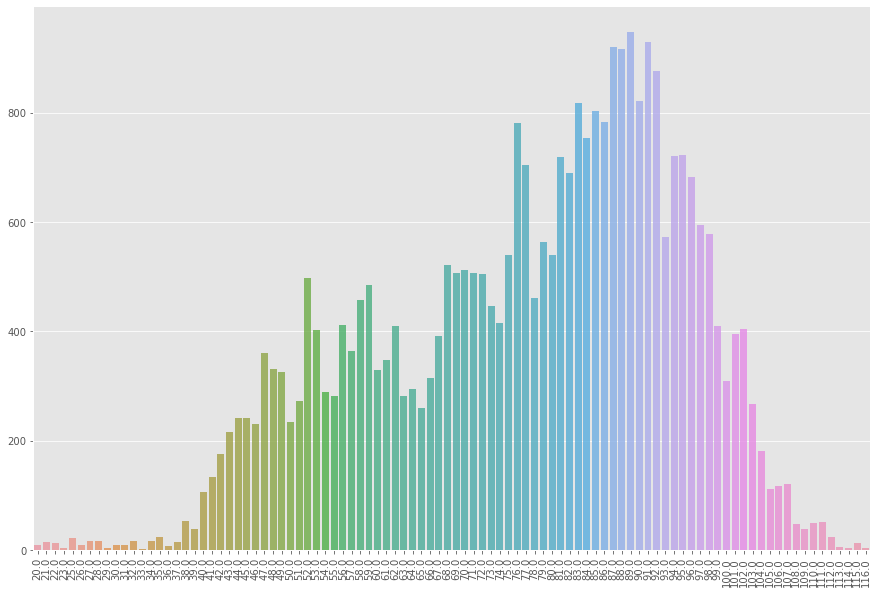

In [38]:
alive = CAge[CAge.indfall=='S']
x = alive.age.value_counts()
plt.figure(figsize=(15,10))
sns.barplot(x.index, x.values, alpha=0.8)
plt.xticks(rotation='90')
plt.show()

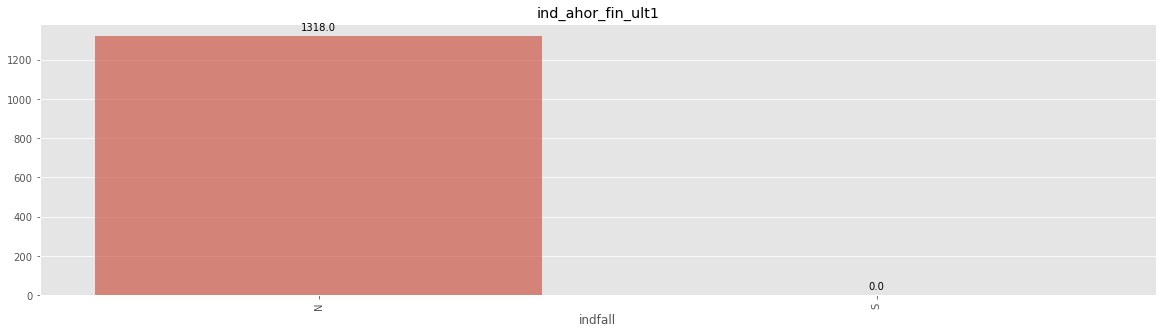

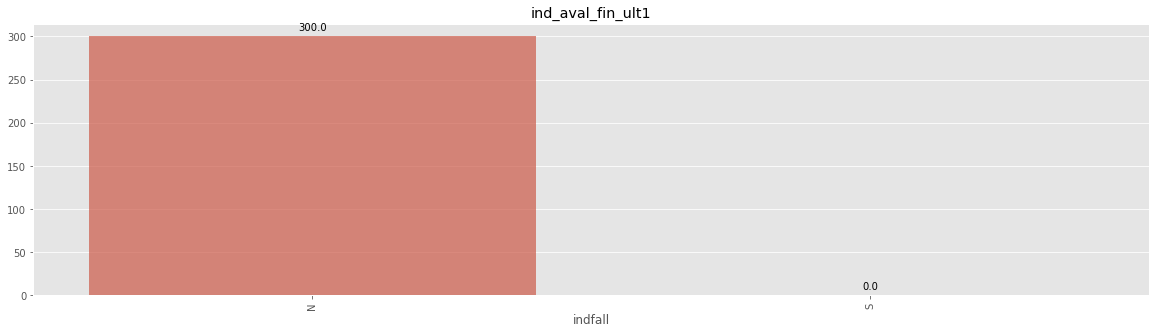

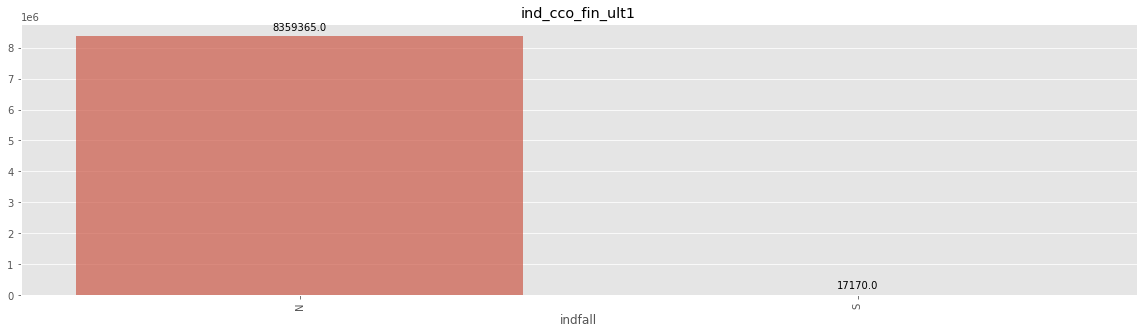

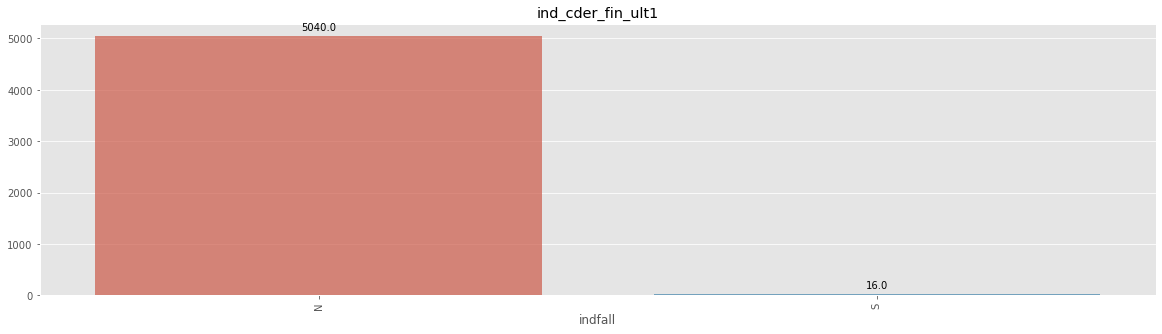

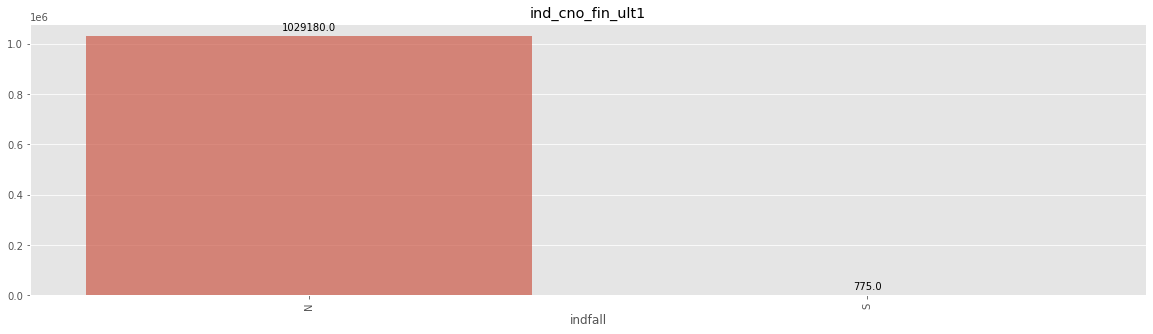

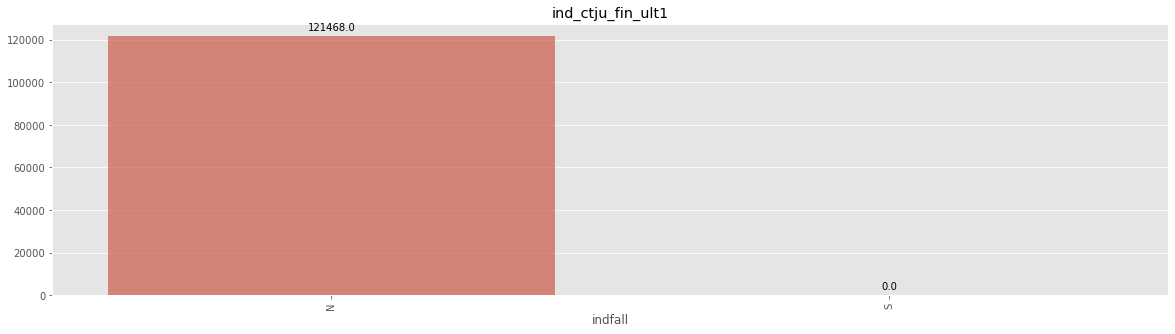

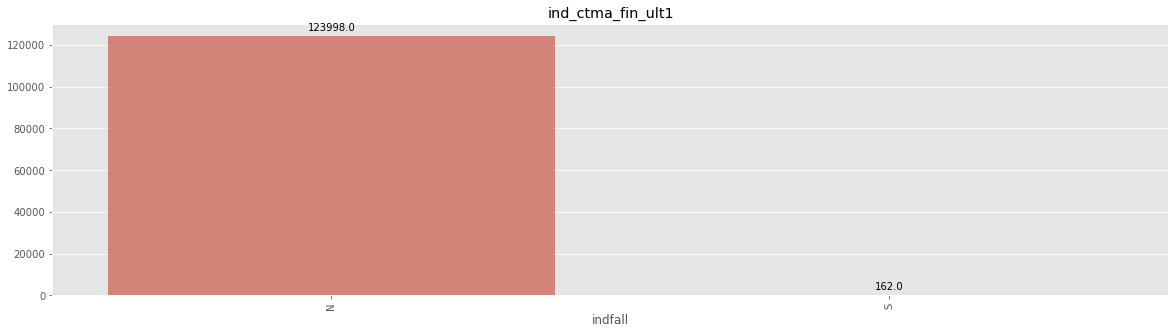

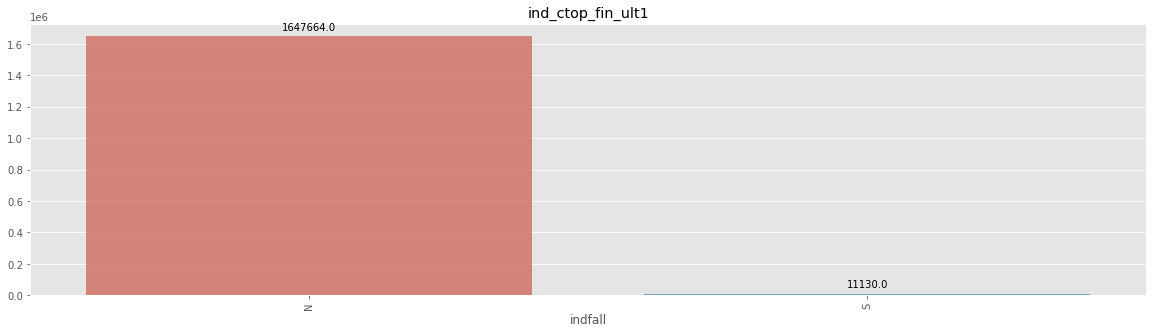

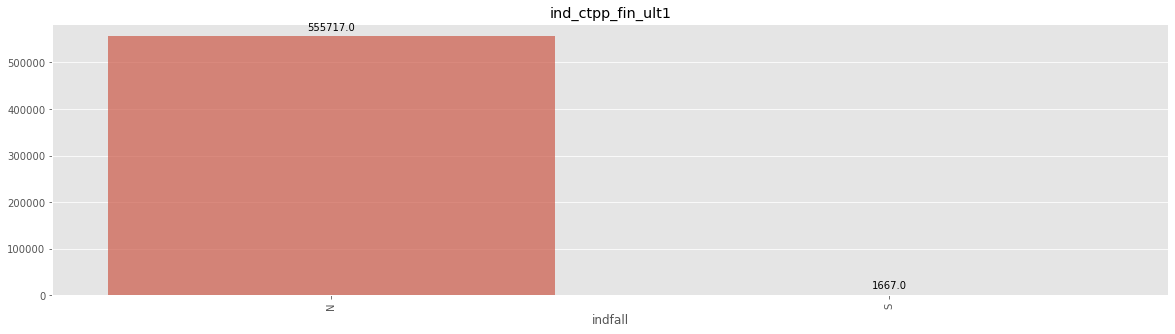

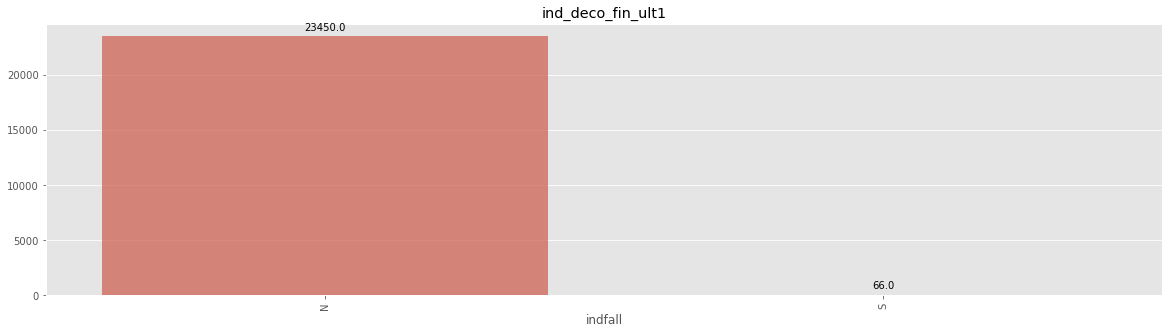

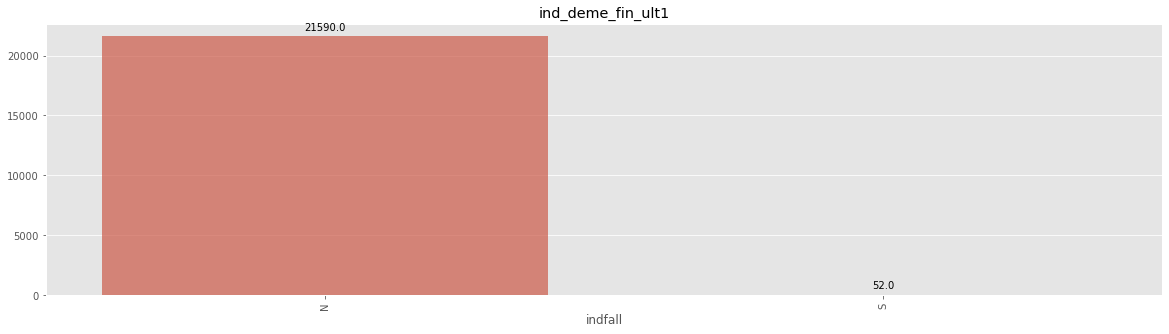

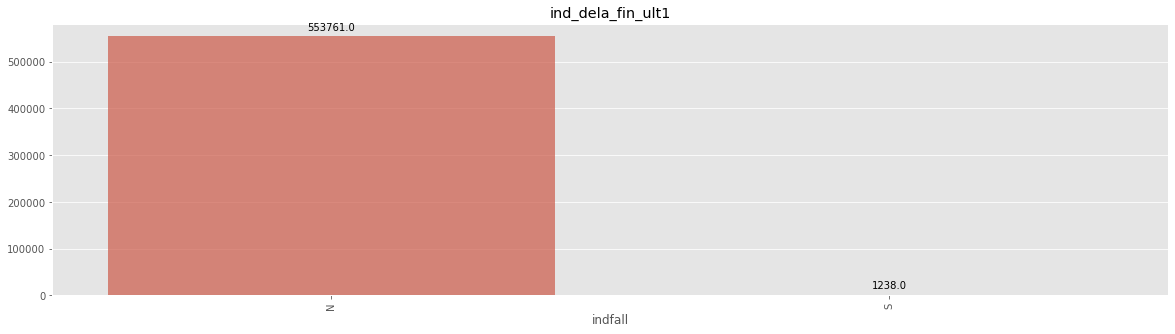

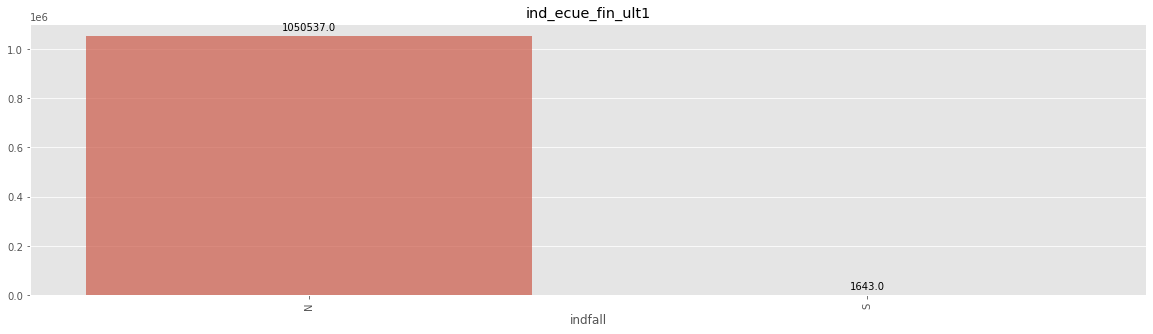

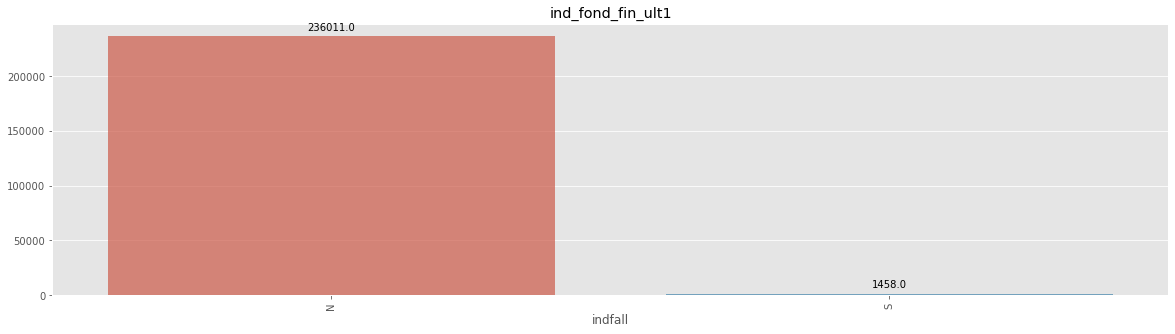

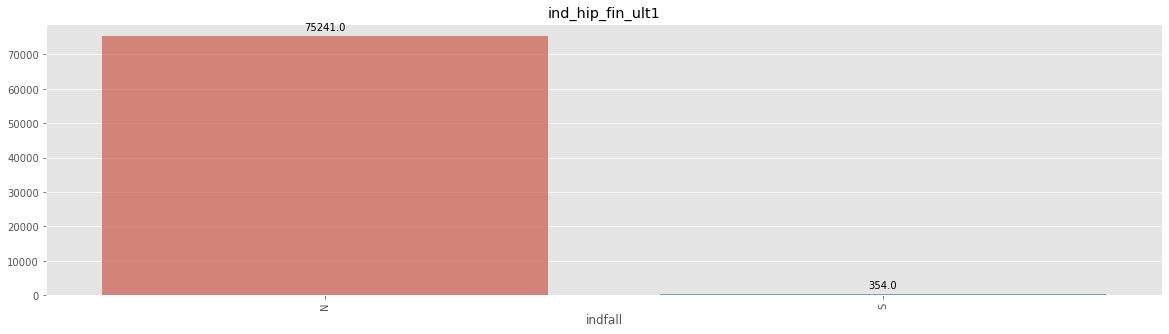

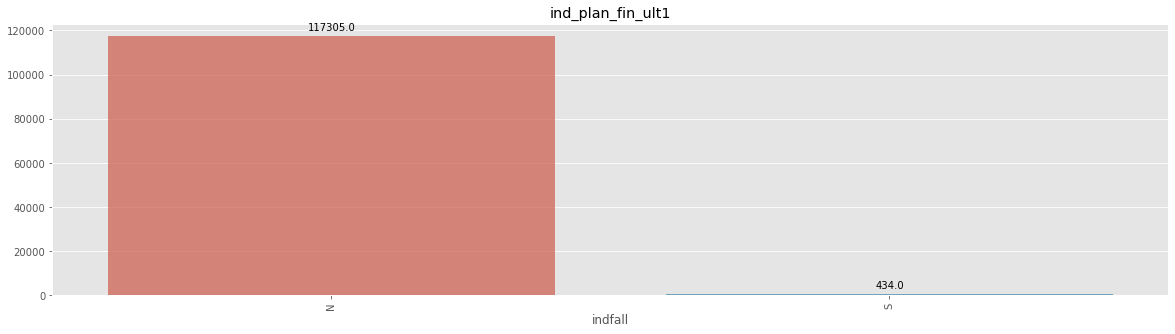

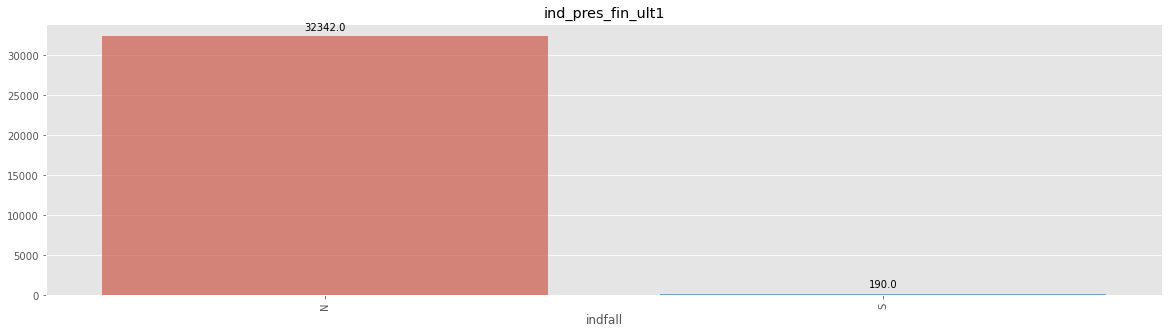

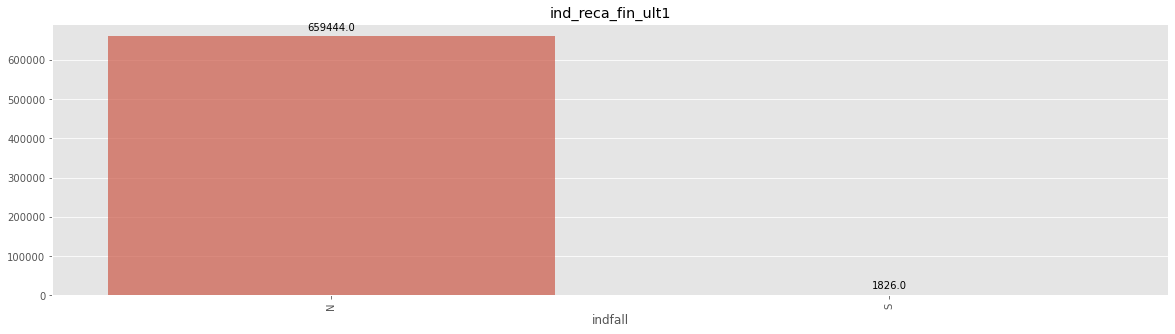

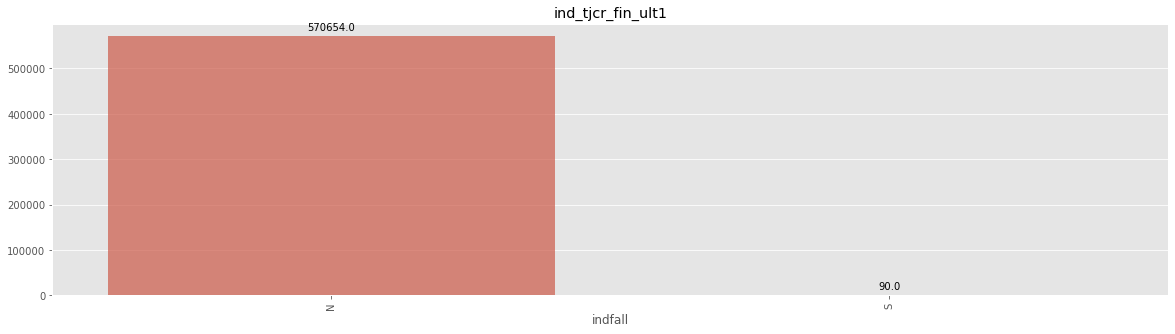

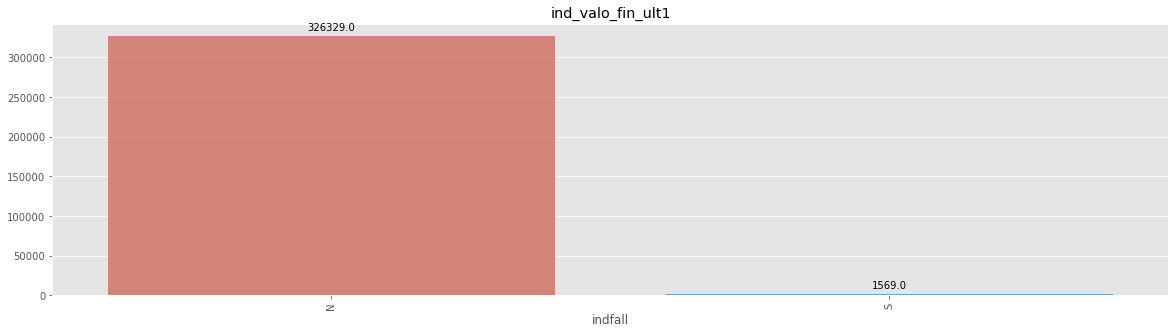

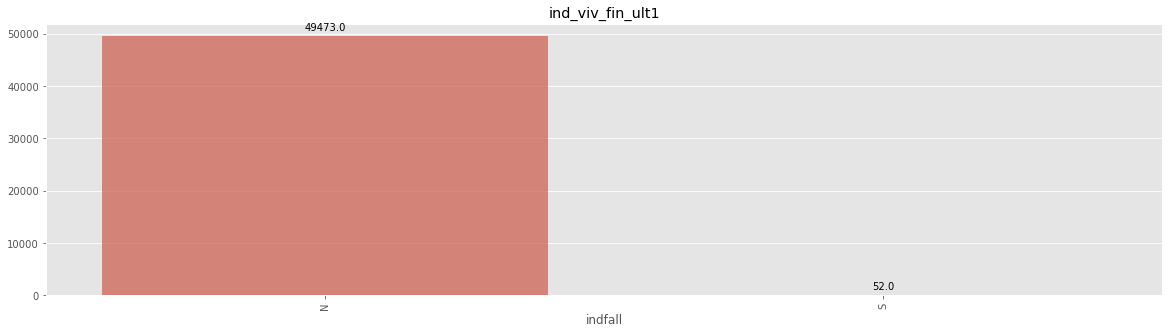

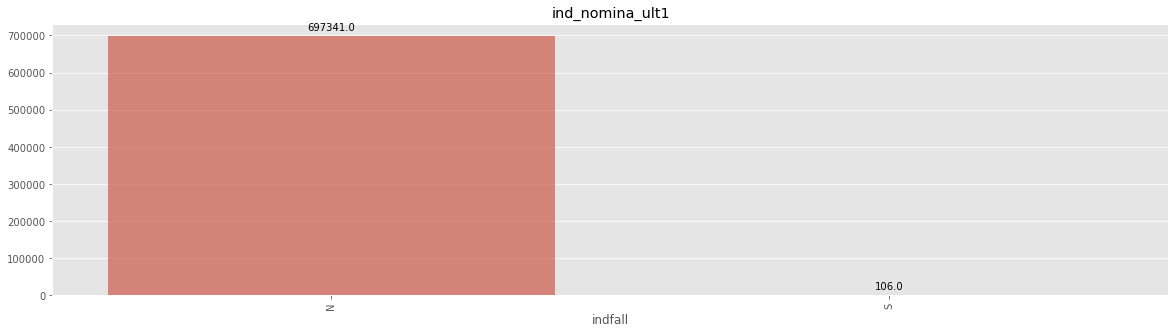

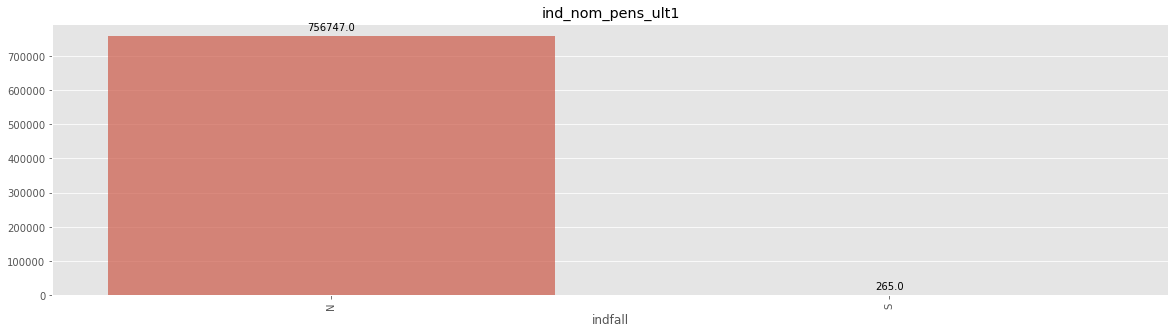

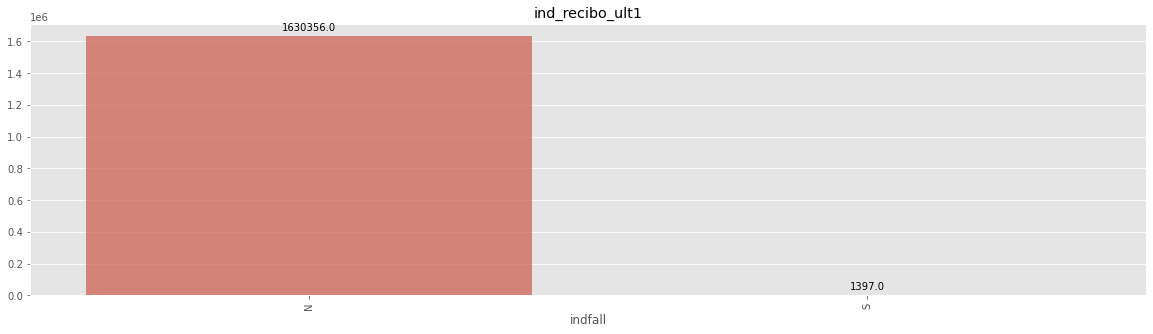

In [39]:
non = CAge[CAge.indfall.isnull()==False]
cols = CAge.loc[:,'ind_ahor_fin_ult1':'ind_recibo_ult1']
x = non.groupby('indfall')
for i in cols.columns:
    y = x[i].sum()
    plt.figure(figsize=(20,5))
    splot = sns.barplot(y.index, y.values, alpha=0.7)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    plt.xticks(rotation='90')
    plt.title(i)
    plt.show()

Checking to see the age distribution of based on Junior Accounts

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


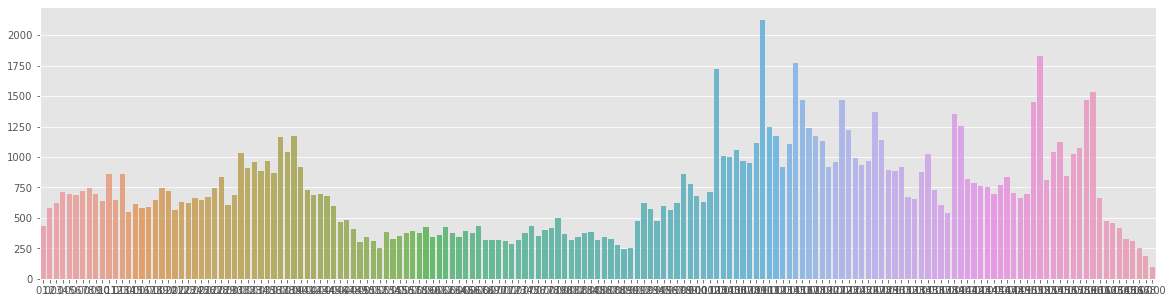

90.6372954193697
104.0


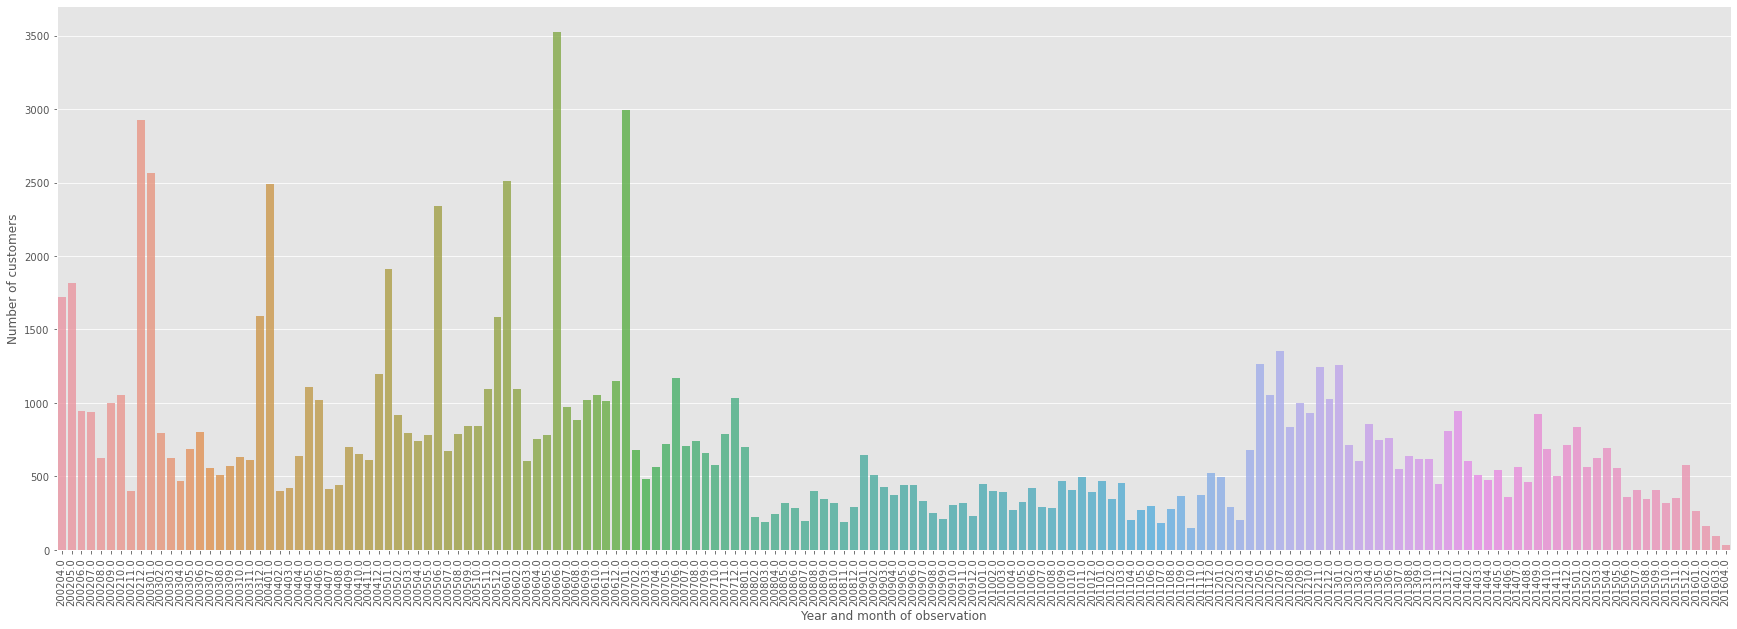

200701.0


In [40]:
junior_age_verify = pd.read_csv("/kaggle/input/santander-pr/train.csv", usecols=["antiguedad","ind_ctju_fin_ult1", "fecha_alta","age"], parse_dates=['fecha_alta'])
junior_age_verify.fecha_alta = junior_age_verify.fecha_alta.apply(lambda x: 100*x.year + x.month)

def string_num_senior(x):
    if(type(x) == str and x != '     NA'):
        x = int(x)
    elif( x == '     NA'):
        x = np.nan
    return x
def string_num_age(x):
    if(type(x) == str and x != ' NA'):
        x = int(x)
    elif( x == ' NA'):
        x = np.nan
    return x
junior_age_verify.age = junior_age_verify.age.apply(lambda x: string_num_age(x))
junior_age_verify.antiguedad = junior_age_verify.antiguedad.apply(lambda x: string_num_senior(x))

jdf = junior_age_verify[(junior_age_verify.ind_ctju_fin_ult1 == 1)].copy(deep=True)

plt.figure(figsize=(20,5))
sns.barplot(jdf.antiguedad.value_counts().index, jdf.antiguedad.value_counts().values, alpha=0.8)
plt.show()

print(jdf.antiguedad.mean())
print(jdf.antiguedad.median())

num_of_cus = jdf['fecha_alta'].value_counts()

plt.figure(figsize=[30,10])
sns.barplot(num_of_cus.index, num_of_cus.values, alpha=0.8)
plt.xlabel('Year and month of observation', fontsize=12)
plt.ylabel('Number of customers', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

print(jdf['fecha_alta'].median())

In [ ]:
##############THIS IS FILLING#################
# CAge.indfall = np.where((CAge.age <= 90) & (CAge.indfall.isnull()),"N", CAge.indfall)
# print(CAge.indfall.isnull().sum())

----------------

## Segmento(FILLED)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55]),
 <a list of 56 Text major ticklabel objects>)

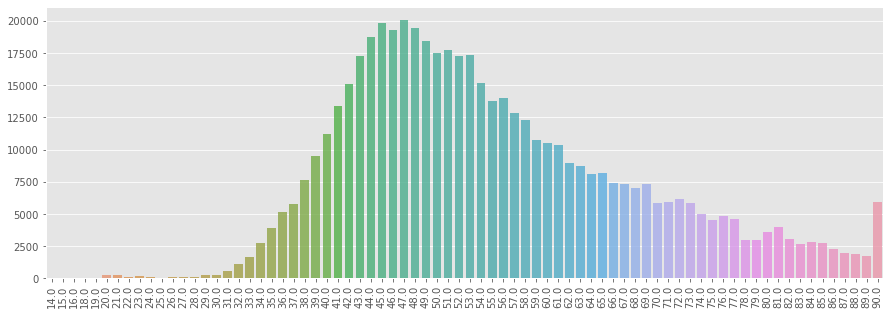

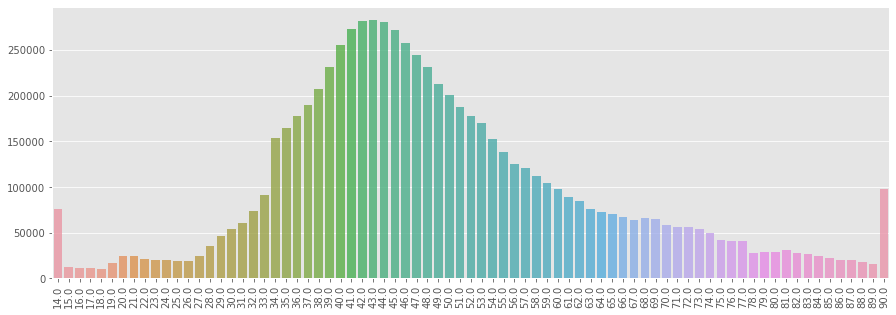

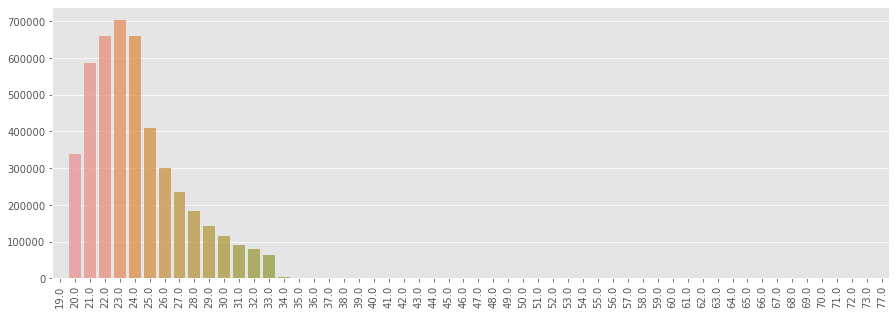

In [41]:
CAge = pd.read_csv("/kaggle/input/santander-pr/train.csv", usecols=["segmento","renta","age", "ind_plan_fin_ult1", "ind_ctju_fin_ult1","ind_nom_pens_ult1"])

def string_num_age(x):
    if(type(x) == str and x != ' NA'):
        x = int(x)
    elif( x == ' NA'):
        x = np.nan
    return x

CAge.age = CAge.age.apply(lambda x: string_num_age(x))
CAge.age = np.where(((CAge.ind_plan_fin_ult1==1) & (CAge.age.isnull())) | ((CAge.ind_nom_pens_ult1 == 1) & (CAge.age.isnull())), 45, CAge.age)
CAge.age = np.where((CAge.segmento=="03 - UNIVERSITARIO") & (CAge.age.isnull()),24, CAge.age)
CAge.age = np.where((CAge.ind_ctju_fin_ult1 == 1) & (CAge.age.isnull()),14, CAge.age)
CAge.age = np.where(CAge.age < 14, 14, CAge.age)
CAge.age = np.where(CAge.age > 90, 90, CAge.age)
CAge.age = CAge.age.fillna(value=40)

top = CAge[CAge.segmento=="01 - TOP"]
plt.figure(figsize=(15,5))
sns.barplot(top.age.value_counts().index, top.age.value_counts().values,alpha=0.8)
plt.xticks(rotation='90')

top = CAge[CAge.segmento=="02 - PARTICULARES"]
plt.figure(figsize=(15,5))
sns.barplot(top.age.value_counts().index, top.age.value_counts().values,alpha=0.8)
plt.xticks(rotation='90')

top = CAge[CAge.segmento=="03 - UNIVERSITARIO"]
plt.figure(figsize=(15,5))
sns.barplot(top.age.value_counts().index, top.age.value_counts().values,alpha=0.8)
plt.xticks(rotation='90')

In [ ]:
###########################THIS IS FILLING#####################
# CAge.segmento = np.where((CAge.segmento.isnull() & (CAge.age <= 33) & (CAge.age >= 20)),"03 - UNIVERSITARIO",CAge.segmento)
# CAge.segmento = np.where((CAge.segmento.isnull() & ((CAge.age > 33) |(CAge.age <20))),"02 - PARTICULARES",CAge.segmento)

-----------------------------------------------------------


## tiprel_1mes(Filled)

In [ ]:
# activity_df = pd.read_csv("/kaggle/input/santander-pr/train.csv", usecols=["ncodpers","ind_ahor_fin_ult1","ind_aval_fin_ult1","ind_cco_fin_ult1","ind_cder_fin_ult1","ind_cno_fin_ult1","ind_ctju_fin_ult1","ind_ctma_fin_ult1",
#                                                                      "ind_ctop_fin_ult1","ind_ctpp_fin_ult1","ind_deco_fin_ult1","ind_deme_fin_ult1","ind_dela_fin_ult1", "ind_ecue_fin_ult1","ind_fond_fin_ult1",
#                                                                      "ind_hip_fin_ult1", "ind_plan_fin_ult1","ind_pres_fin_ult1","ind_reca_fin_ult1","ind_tjcr_fin_ult1","ind_valo_fin_ult1","ind_viv_fin_ult1",
#                                                                      "ind_nomina_ult1","ind_nom_pens_ult1","ind_recibo_ult1","tiprel_1mes",'fecha_dato'], parse_dates=['fecha_dato'])

# activity_df['total_products'] = activity_df.loc[:,"ind_ahor_fin_ult1":"ind_recibo_ult1"].sum(axis=1)
# activity_df['dates'] = activity_df['fecha_dato'].apply(lambda x: 100*x.year + x.month)

In [ ]:
# Total products versus the tiprel_1mes
# tp = activity_df[["total_products","tiprel_1mes"]]

# x1 = tp.loc[tp.tiprel_1mes == 'A', 'total_products']
# x2 = tp.loc[tp.tiprel_1mes == 'I', 'total_products']
# x3 = tp.loc[tp.tiprel_1mes == 'P', 'total_products']
# x4 = tp.loc[tp.tiprel_1mes == 'R', 'total_products']
# x5 = tp.loc[tp.tiprel_1mes == 'N', 'total_products']

# kwargs = dict(alpha=0.5, bins=16)
# f, ax = plt.subplots(figsize=(10, 10))

# plt.hist(x1, **kwargs, color='g', label='Active-A')
# plt.hist(x2, **kwargs, color='b', label='Inactive-I')
# plt.hist(x3, **kwargs, color='r', label='Former Customer-P')
# plt.hist(x4, **kwargs, color='c', label='Potential-R')
# plt.hist(x5, **kwargs, color='m', label='N')
# plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
# plt.xlim(0,15)
# plt.legend();
# ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

# # Ratio of Active vs Inactive choice of products
# products = activity_df.loc[:,"ind_ahor_fin_ult1":"ind_recibo_ult1"].columns
# for i in products:
#     pos = activity_df.groupby(i)["tiprel_1mes"].value_counts()[1]
#     try:
#         print(i + "Ratio of Active vs Inactive")
#         print((pos.A)/pos.I)
#     except:
#         continue

Looking at the categorical variables, A and I are very high as compared to P,R,N.
What we have now, is the ratio of count of customers of each type who purchased the different products. The highlighted features are those that I decided to keep as the baseline for classifying the customer as active or inactive. 
In addition to it, we must ensure that after a person becomes former customer, they are gonna remain former. So, verify for a given customer if he/she became Former earlier. ***This is redundant since no null values after Former customer identitification***


ind_ahor_fin_ult1 :2.496021220159151

ind_cco_fin_ult1 : 0.9672413593025346

ind_cder_fin_ult1 : 336.0

ind_cno_fin_ult1 : 83.63569842966373

ind_ctju_fin_ult1 : 4.101437060137385

ind_ctma_fin_ult1 : 3.0434926191341103

ind_ctop_fin_ult1 : 1.9199971834952823

ind_ctpp_fin_ult1 : 3.931178781230094

ind_deco_fin_ult1 : 29.476697736351532

ind_deme_fin_ult1 : 266.18518518518516

ind_dela_fin_ult1 : 215.92960500586625

ind_ecue_fin_ult1 : 12.053598679884367

`ind_fond_fin_ult1 : 3768.2063492063494`

`ind_hip_fin_ult1 : 3778.75`

`ind_plan_fin_ult1 : 1164.6831683168316`

ind_pres_fin_ult1 : 261.35483870967744

ind_reca_fin_ult1 : 6.873998213754094

ind_tjcr_fin_ult1 : 324.7648401826484

ind_valo_fin_ult1 : 1141.4285714285713

ind_viv_fin_ult1 : 2.9343025103272957

ind_nomina_ult1 : 129.4568594422609

ind_nom_pens_ult1 : 127.69365538356864

ind_recibo_ult1 : 62.608197168818

### Alternate way:
Given that the count of the null values of tiprel_1mes 145771 are just 1% of the total data, we can impute the value `N` (Assume it to be unkown). There is a possibility that for these customers the "activity" wouldn't have been possible to decide.  

In [ ]:
# Look at the former customer category
# former = []
# for i in activity_df.groupby("tiprel_1mes").get_group('P').ncodpers:
#     if i not in former:
#         former.append(i)

# cus = activity_df.groupby('ncodpers')
# for i in former:
#     x = cus.get_group(i)
#     date=0
#     for index, row in x.iterrows():
#         if((date != 0) & (row.tiprel_1mes == 'nan')):
#             activity_df["tiprel_1mes"] = np.where((activity_df.dates == row.dates) & (activity_df.ncodpers == i) & (activity_df.tiprel_1mes.isnull()), 'P',activity_df.tiprel_1mes)
#         elif(row.tiprel_1mes == 'P'):
#             date = row.dates

In [ ]:
#############################THIS IS THE FILLING##############################
# activity_df["tiprel_1mes"] = np.where(((activity_df.ind_fond_fin_ult1 == 1) | (activity_df.ind_hip_fin_ult1 == 1) | (activity_df.ind_plan_fin_ult1 == 1)) & (activity_df.tiprel_1mes.isnull()) , 'A', activity_df.tiprel_1mes)
# activity_df["tiprel_1mes"] = np.where(((activity_df.ind_fond_fin_ult1 != 1) | (activity_df.ind_hip_fin_ult1 != 1) | (activity_df.ind_plan_fin_ult1 != 1)) & (activity_df.tiprel_1mes.isnull()) , 'I', activity_df.tiprel_1mes)

----------------------------------------

## indrel_1mes

Fill at the end, based on age as well. 

Look at the ordering:
- If indrel = 1, indrel_1mes will be 1 obviously
- If indrel = 99, 
    - it can be 2,3,4 or P
    - For this only way is too look at the products for each of 2,3,4, and P and report the one which matches the most with this

In [ ]:
# primary_df = pd.read_csv("/kaggle/input/santander-pr/train.csv", usecols=["ind_ahor_fin_ult1","ind_aval_fin_ult1","ind_cco_fin_ult1","ind_cder_fin_ult1","ind_cno_fin_ult1","ind_ctju_fin_ult1","ind_ctma_fin_ult1",
#                                                                      "ind_ctop_fin_ult1","ind_ctpp_fin_ult1","ind_deco_fin_ult1","ind_deme_fin_ult1","ind_dela_fin_ult1", "ind_ecue_fin_ult1","ind_fond_fin_ult1",
#                                                                      "ind_hip_fin_ult1", "ind_plan_fin_ult1","ind_pres_fin_ult1","ind_reca_fin_ult1","ind_tjcr_fin_ult1","ind_valo_fin_ult1","ind_viv_fin_ult1",
#                                                                      "ind_nomina_ult1","ind_nom_pens_ult1","ind_recibo_ult1", "indrel_1mes", "indrel", "age"])
# primary_df["index"] = np.array(range(primary_df.shape[0]))
# primary_df.set_index('index')

In [ ]:
# import math

# def string_num_primary(x):
#     if(type(x) == int and x!= np.nan):
#         x = int(x)
#         x = str(x)
#     elif(type(x) == float and math.isnan(x)==False):
#         x = int(x)
#         x = str(x)
#     elif(type(x) == float and math.isnan(x)):
#         x = "NA"
#     return x

# def fti_string(x):
#     if(type(x) == str and x != 'NA'):
#         if(x.find(".") != -1):
#             t = float(x)
#             t = int(t)
#             x = str(t)
#     return x

# primary_df["indrel_1mes"] = primary_df["indrel_1mes"].apply(lambda x: string_num_primary(x))
# primary_df["indrel_1mes"] = primary_df["indrel_1mes"].apply(lambda x: fti_string(x))

In [ ]:
##################PARTIAL FILLING DONE LIKE THIS#############
# primary_df.indrel_1mes = np.where((primary_df.indrel_1mes=='NA') & (primary_df.indrel==1),"1",primary_df.indrel_1mes)

In [ ]:
# cols = primary_df.loc[:,"ind_ahor_fin_ult1":"ind_nomina_ult1"].columns


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

## indresi, codprov and pais_residencia(DROPPED)  nomprov(FILLED)

ES - Spain \
DE - Germany \
IT - Italy \
BO - Bolivia? \
PY - Paraguay

We can drop nomprov and hence codprov, since it is highly unbalanced. Most of the values correspond to Madrid and hence won't provide much insights. \
Same reason drop indresi and pais_residencia

In [ ]:
# primary_df = pd.read_csv("/kaggle/input/santander-pr/train.csv", usecols=[ "indresi","pais_residencia","nomprov","ind_ahor_fin_ult1","ind_aval_fin_ult1","ind_cco_fin_ult1","ind_cder_fin_ult1","ind_cno_fin_ult1","ind_ctju_fin_ult1","ind_ctma_fin_ult1",
#                                                                      "ind_ctop_fin_ult1","ind_ctpp_fin_ult1","ind_deco_fin_ult1","ind_deme_fin_ult1","ind_dela_fin_ult1", "ind_ecue_fin_ult1","ind_fond_fin_ult1",
#                                                                      "ind_hip_fin_ult1", "ind_plan_fin_ult1","ind_pres_fin_ult1","ind_reca_fin_ult1","ind_tjcr_fin_ult1","ind_valo_fin_ult1","ind_viv_fin_ult1",
#                                                                      "ind_nomina_ult1","ind_nom_pens_ult1","ind_recibo_ult1"])

In [ ]:
# nonnull_ind = primary_df[primary_df.nomprov.isnull()==False][["nomprov","pais_residencia","indresi"]]

# print(nonnull_ind.nomprov.unique())
# print(nonnull_ind.pais_residencia.unique())
# print(nonnull_ind.indresi.unique())

# prov = nonnull_ind[nonnull_ind.pais_residencia!='ES'].copy(deep=True)
# print(prov.groupby('pais_residencia').get_group('IT').nomprov.unique())
# print(prov.groupby('pais_residencia').get_group('DE').nomprov.unique())
# print(prov.groupby('pais_residencia').get_group('BO').nomprov.unique())
# print(prov.groupby('pais_residencia').get_group('PY').nomprov.unique())

# prov = nonnull_ind[nonnull_ind.indresi=='N']
# print(prov.nomprov.unique())
# print(prov.pais_residencia.unique())
# nprov = nonnull_ind[nonnull_ind.indresi=='S']
# print(nprov.pais_residencia.unique())

# prod = primary_df.loc[(primary_df.nomprov == 'MADRID') | (primary_df.nomprov == 'GUADALAJARA') | (primary_df.nomprov == 'PALMAS, LAS')]

# cols = primary_df.loc[:,'ind_ahor_fin_ult1':'ind_viv_fin_ult1']
# x = prod.groupby('nomprov')
# for i in cols.columns:
#     plt.figure(figsize=(15,5))
#     y = x[i].sum()
#     sns.barplot(y.index, y.values, alpha=0.7)
#     plt.title(i)
#     plt.show()

# prod = primary_df.loc[(primary_df.nomprov.isnull() == False)]
# cols = primary_df.loc[:,'ind_ahor_fin_ult1':'ind_viv_fin_ult1']
# x = prod.groupby('nomprov')
# for i in cols.columns:
#     plt.figure(figsize=(15,5))
#     y = x[i].sum()
#     sns.barplot(y.index, y.values, alpha=0.7)
#     plt.title(i)
#     plt.xticks(rotation='90')
#     plt.show()
#     break

In [ ]:
#####################DECIDING TO KEEP NOMPROV FOR NOW#####################
# df["nomprov"] = df["nomprov"].fillna(values='Unk')

--------------------

## indext(Filled)

In [ ]:
# primary_df = pd.read_csv("/kaggle/input/santander-pr/train.csv", usecols=[ "indext","pais_residencia","indresi","ind_ahor_fin_ult1","ind_aval_fin_ult1","ind_cco_fin_ult1","ind_cder_fin_ult1","ind_cno_fin_ult1","ind_ctju_fin_ult1","ind_ctma_fin_ult1",
#                                                                      "ind_ctop_fin_ult1","ind_ctpp_fin_ult1","ind_deco_fin_ult1","ind_deme_fin_ult1","ind_dela_fin_ult1", "ind_ecue_fin_ult1","ind_fond_fin_ult1",
#                                                                      "ind_hip_fin_ult1", "ind_plan_fin_ult1","ind_pres_fin_ult1","ind_reca_fin_ult1","ind_tjcr_fin_ult1","ind_valo_fin_ult1","ind_viv_fin_ult1",
#                                                                      "ind_nomina_ult1","ind_nom_pens_ult1","ind_recibo_ult1"])

# prod = primary_df[primary_df.indext.isnull()==False]
# cols = primary_df.loc[:,'ind_ahor_fin_ult1':'ind_viv_fin_ult1']
# x = prod.groupby('indext')
# for i in cols.columns:
#     plt.figure(figsize=(15,5))
#     y = x[i].sum()
#     splot = sns.barplot(y.index, y.values, alpha=0.7)
#     for p in splot.patches:
#         splot.annotate(format(p.get_height(), '.1f'), 
#                    (p.get_x() + p.get_width() / 2., p.get_height()), 
#                    ha = 'center', va = 'center', 
#                    xytext = (0, 9), 
#                    textcoords = 'offset points')
#     plt.title(i)
#     plt.xticks(rotation='90')
#     plt.show()
#     print(y.values[1]/y.values[0])

In [ ]:
###############FILLING NULL VALUES AS SUCH#############
# df["indext"] = df["indext"].fillna(values='U')

Fill with a new Category 'U' for unkown. \
Reason: We know that this being a time series data, each entry will be influential in determining the outcome. Furthermore, randomly placing indext values might not be a good idea, even though the null value count is less and the data is almost balanced( Assuming less than 1% to be unbalanced). So create a new category to fill in the NULL Values. 

----

## ind_empleado(DROPPED)

In [ ]:
# primary_df = pd.read_csv("/kaggle/input/santander-pr/train.csv", usecols=[ "ind_empleado","pais_residencia","ind_ahor_fin_ult1","ind_aval_fin_ult1","ind_cco_fin_ult1","ind_cder_fin_ult1","ind_cno_fin_ult1","ind_ctju_fin_ult1","ind_ctma_fin_ult1",
#                                                                      "ind_ctop_fin_ult1","ind_ctpp_fin_ult1","ind_deco_fin_ult1","ind_deme_fin_ult1","ind_dela_fin_ult1", "ind_ecue_fin_ult1","ind_fond_fin_ult1",
#                                                                      "ind_hip_fin_ult1", "ind_plan_fin_ult1","ind_pres_fin_ult1","ind_reca_fin_ult1","ind_tjcr_fin_ult1","ind_valo_fin_ult1","ind_viv_fin_ult1",
#                                                                      "ind_nomina_ult1","ind_nom_pens_ult1","ind_recibo_ult1"])

# print(primary_df.ind_empleado.isnull().sum())
# print(primary_df.ind_empleado.value_counts())

(3347+2371+2344+16)*100/12680044

------------------

## sexo(FILLED)

In [ ]:
primary_df = pd.read_csv("/kaggle/input/santander-pr/train.csv", usecols=[ "sexo","ind_ahor_fin_ult1","ind_aval_fin_ult1","ind_cco_fin_ult1","ind_cder_fin_ult1","ind_cno_fin_ult1","ind_ctju_fin_ult1","ind_ctma_fin_ult1",
                                                                     "ind_ctop_fin_ult1","ind_ctpp_fin_ult1","ind_deco_fin_ult1","ind_deme_fin_ult1","ind_dela_fin_ult1", "ind_ecue_fin_ult1","ind_fond_fin_ult1",
                                                                     "ind_hip_fin_ult1", "ind_plan_fin_ult1","ind_pres_fin_ult1","ind_reca_fin_ult1","ind_tjcr_fin_ult1","ind_valo_fin_ult1","ind_viv_fin_ult1",
                                                                     "ind_nomina_ult1","ind_nom_pens_ult1","ind_recibo_ult1"])

In [ ]:
print(primary_df.sexo.value_counts())
print(primary_df.sexo.isnull().sum())

In [ ]:
import random
primary_df.sexo = np.where(primary_df.sexo.isnull(), random.choice(["V","H"]),primary_df.sexo)
print(primary_df.sexo.value_counts())
print(primary_df.sexo.isnull().sum())

-------------

## Canal_entrada(DROP)

In [ ]:
pd.set_option('display.max_rows', 40)

In [ ]:
primary_df = pd.read_csv("/kaggle/input/santander-pr/train.csv", usecols=[ "canal_entrada"])
primary_df.value_counts()

------------

## ind_nuevo, antiguedad

In [ ]:
df = pd.read_csv("/kaggle/input/santander-pr/train.csv", usecols=["ind_nuevo", "antiguedad", "fecha_alta"], parse_dates = ["fecha_alta"])

def string_num_senior(x):
    if(type(x) == str and x != '     NA'):
        x = int(x)
    elif( x == '     NA'):
        x = np.nan
    return x

df["antiguedad"] = df.antiguedad.apply(lambda x: string_num_senior(x))

We don't know the seniority so the -99999 is like the UNKOWN tag and so correspondingly we can assume that the few customers are old hence 0

In [ ]:
df.ind_nuevo =df.ind_nuevo.fillna(value=0)
df.antiguedad = df.antiguedad.fillna(value=-999999)